In [4]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Patch
import numpy as np
from collections import Counter, OrderedDict
import ast

import json
import pickle

import warnings

from Bio import SeqIO, pairwise2, PDB

from ete3 import Tree, NodeStyle, TextFace, TreeStyle #AttrFace, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, 



import sys
# if not(base_dir in sys.path): 
#     sys.path.append(base_dir)
#     print("Added " + base_dir + " to path" )


yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")

if yeast_esr_flag =='Y':
    yeast_esr_exp_path = os.path.normpath('C:/Users/heine/github/yeast_esr_expression_analysis') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(yeast_esr_exp_path in sys.path):
        sys.path.append(yeast_esr_exp_path)
        print("Added " + yeast_esr_exp_path + " to path" )

    import yeast_esr_exp
    yeast_esr_exp.base_dir = yeast_esr_exp_path
    yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep


y1000plus_tools_flag = input("Use y1000plus_tools functions? (Y/n)")

if y1000plus_tools_flag =='Y':
    y1000plus_tools_path = os.path.normpath('C:/Users/heine/github/y1000plus_tools') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(y1000plus_tools_path in sys.path):
        sys.path.append(y1000plus_tools_path)
        print("Added " + y1000plus_tools_path + " to path" )

    import y1000plus_tools
    y1000plus_tools.base_dir = os.path.normpath('C:/Users/heine/github/y1000plus_tools') + os.sep
    print("y1000plus_tools dir is " + y1000plus_tools.base_dir )                      
    y1000plus_tools.y1000plus_dir = y1000plus_tools.base_dir + 'data' + os.sep 
    print("y1000plus data dir is " + y1000plus_tools.y1000plus_dir)



    
#from venn import venn


genomes_base = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')
y1000plus_dir = os.path.normpath('C:/Users/heine/github/y1000plus_tools') + os.sep
base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts')




#Load y1000 species table
y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

#Load S.Cer lookup table: 
scer_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/saccharomyces_cerevisiae.csv')

scer_lookup = pd.read_csv(scer_lookup_fname, index_col=0)
scer_y1000_id_gene_id_lookup = dict(zip(scer_lookup['y1000_id'], scer_lookup.index))

spec_orig_genome_lookup = dict(zip(y1000_species['spec_og_id'], y1000_species['original_genome_id']))

protein_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 

#Percentage of species that need to be present in the orthogroup in order to use the orthogroup. 
pct_present_thresh = 0.4


Use yeast_esr_expression functions? (Y/n)n
Use y1000plus_tools functions? (Y/n)n


In [14]:
sc_annotations_df = pd.read_csv(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_annotation_summary_20211007.csv', index_col = 0)

scer_orf_table = pd.read_table(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_orf_list_20211025.tsv', index_col=1, names= ['SGD_id', 'species', 'Name', 'full_name', 'qualifier', 'status'])

scer_orf_table_not_dub = scer_orf_table[scer_orf_table['qualifier'] != 'Dubious']

sc_annotations_orf = sc_annotations_df.loc[list(set(sc_annotations_df.index) & set(scer_orf_table_not_dub.index ))]

ec_counts = []
for eclist in sc_annotations_orf['EC number']: 
    if type(eclist)==float:
        assert np.isnan(eclist), 'Float but not NaN ' + eclist
        ec_counts.append(0)
    else: 
        eclist_list = ast.literal_eval(eclist)
        ec_counts.append(len(eclist_list))
        

print('{} s. cerevisiae proteins with an EC number'.format(sum(~(sc_annotations_orf['EC number'].isna()))))


## How many have a PDB annotation

print('{} s. cerevisiae proteins with a PDB id'.format(sum(~(sc_annotations_orf['PDB ID'].isna()))))

sc_annotations_ec_subset = sc_annotations_orf[~(sc_annotations_orf['EC number'].isna())]

print('{} s. cerevisiae proteins with and EC number and a PDB id'.format(sum(~(sc_annotations_ec_subset['PDB ID'].isna()))))

## How many have a pathway identified

sc_annotations_orf['N_pathways'] = [len(ast.literal_eval(pway_list)) for pway_list in sc_annotations_orf['Gene.pathways.name']]

sc_annotations_orf[sc_annotations_orf['N_pathways']>0]

# N_pathways_EC = pd.Series([len(ast.literal_eval(pway_list)) for pway_list in sc_annotations_ec_subset['Gene.pathways.name']])

print('{} s. cerevisiae proteins with a Pathway'.format(sum(sc_annotations_orf['N_pathways']>0)))

print('{} s. cerevisiae proteins with and EC number and a Pathway'.format(sum(((sc_annotations_orf['N_pathways']>0) & (~(sc_annotations_orf['EC number'].isna()))))))


sc_annotations_pway_subset = sc_annotations_orf[sc_annotations_orf['N_pathways']>0]



1373 s. cerevisiae proteins with an EC number
1083 s. cerevisiae proteins with a PDB id
299 s. cerevisiae proteins with and EC number and a PDB id
517 s. cerevisiae proteins with a Pathway
469 s. cerevisiae proteins with and EC number and a Pathway


In [ ]:
#Proteins missing yeast EC number but which have a curated pathway
sc_annotations_orf[(sc_annotations_orf['N_pathways']>0) & sc_annotations_orf['EC number'].isna()]

#This list makes me think that we want the pathways and not to rely exclusively on EC numbers (since there are some potentially very interesting enzymes in here)

In [ ]:
# Summarize size distribution of ortholog mappings: 
orthogroup_fname = y1000plus_dir + os.path.normpath("shen_2018_data/orthomcl_output/orthomcl_clusters.txt")

og_sizes = []

with open(orthogroup_fname, 'r') as f: 
    for line in f: 
        og_genes = line.split()
        og = og_genes[0].strip(':')
        genes = og_genes[1:]
        og_sizes.append(len(genes))
        
fig, ax = plt.subplots(1,1)

ax.hist(og_sizes, log=True, bins = 50)
ax.set_title('Orthogroup Sizes from Shen et al 2018')
ax.set_xlabel('Size of orthogroup')
ax.set_ylabel('Frequency (Log scale)')

In [ ]:
# For a given S. cerevisiae protein, provide its og number
# Make mapping of S. cerevisiae proteins to orthogroups

# Species
spec_name = 'Saccharomyces cerevisiae'

#y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

spec_id = y1000_species[y1000_species['Species name']==spec_name]['spec_og_id'].values[0]

spec_og_mapping = {}
with open(orthogroup_fname, 'r') as f: 
    for line in f: 
        og_genes = line.split()
        og = og_genes[0].strip(':')
        genes = og_genes[1:]
        
        gene_ids = [gene_id for gene_id in genes if int(gene_id.split('_')[0])==spec_id]
        
        if len(gene_ids) >= 1:
            for gene_id in gene_ids: 
                spec_og_mapping[gene_id] = og

                
og_set = []

for sc_genename in sc_annotations_pway_subset.index:   #sc_annotations_ec_subset.index: 
    #sc_genename = 'YER144C'
    y1000_id = scer_lookup.loc[sc_genename, 'y1000_id']
    og_in = spec_og_mapping[y1000_id]
    og_set.append(og_in)
    
og_set = list(set(og_set))

print('{} orthogroups contain S. cerevisiae genes with SGD curated pathway'.format(len(og_set)))

In [27]:
#species_set = pd.read_table(os.path.normpath(base_dir + '/alphafold/species_selection.txt'), index_col = 0)
#Species name	Time_tree_name	original_genome_id	Abbreviation	spec_og_id	Alphafold_structures	Long_read_seqs	Experimental_data	Major clade	Load	Uniprot Proteome	CUG usage	Notes	Sequence source for Alphafold	Sequence Source for Trees	Genome Sequence for Uniprot

species_set = pd.read_csv(os.path.normpath(base_dir + '/alphafold/selected_proteins/species_selection/species_selection.csv'), index_col = 0)
species_set_filt = species_set.loc[species_set['Load']=='Y']

spec_id_map = {}
time_tree_names = []
for spec_fullname, (time_tree_name, jacobs_name, spec_orig, spec_abbrev, spec_abbrev_2, spec_og_id, alphafold_structures,long_read_flag, experimental_data, experimental_data_used, clade, load_flag, uniprot, cug_usage, notes, seq_source_af, uniprot_genome) in species_set_filt.iterrows():
    y1000_spec_lookup = y1000_species[y1000_species['original_genome_id']==spec_orig]
    clade_true = y1000_spec_lookup['Major clade'].values[0]
    assert clade_true==clade, 'Clade mismatch: {}, true spelling: {}, bad spelling: {}'.format(spec_fullname, clade_true, clade)
    spec_id = y1000_spec_lookup['spec_og_id'].values[0]
    assert spec_og_id == spec_id, 'OG id mismatch: {}, from species selection table: {}, from original database: {}'.format(spec_fullname, spec_og_id, spec_id)
    spec_id_map[int(spec_og_id)] = spec_orig
    time_tree_names.append(time_tree_name)
    
# spec_ids = set([str(spec_id_int) for spec_id_int in spec_id_map.keys()])

In [14]:
#Make tree for all species

tree_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/shen_2018_data/data_in_Figure2/332_2408OGs_time-calibrated_phylogeny_species-names_updated.newick')
t = Tree(tree_fname)

#clade_color_lookup = y1000_clade_color_lookup(y1000_species_fname =y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"))
clade_lookup = dict(zip(species_set_filt['Time_tree_name'], species_set_filt['Major clade']))
tab20_cmap = cm.tab20

#get_clade_order
clade_order = []
for jj, node in enumerate(t.get_leaves()):
    clade = clade_lookup[node.name]
    if not(clade in clade_order):
        clade_order.append(clade)

#clade_color_lookup = {clade:colors.to_hex(tab20_cmap(11-jj)) for (jj,clade) in enumerate(clade_order)}

clade_order_curated = clade_order.copy()
clade_order_curated.remove('Saccharomycetaceae')
clade_order_curated = ['Outgroup'] + clade_order_curated + ['Saccharomycetaceae, KLE', 'Saccharomycetaceae, ZT', 'Saccharomycetaceae, post WGH']

clade_color_lookup = {'Outgroup': colors.to_hex(tab20_cmap(15)), 
                      'Lipomycetaceae': colors.to_hex(tab20_cmap(14)),
                      'Trigonopsidaceae': colors.to_hex(tab20_cmap(11)),
                      'Dipodascaceae/Trichomonascaceae': colors.to_hex(tab20_cmap(10)),
                      'Alloascoideaceae': colors.to_hex(tab20_cmap(13)),
                      'Sporopachydermia clade': colors.to_hex(tab20_cmap(12)),
                      'CUG-Ala': colors.to_hex(tab20_cmap(3)),
                      'Pichiaceae': colors.to_hex(tab20_cmap(2)),
                      'CUG-Ser1': colors.to_hex(tab20_cmap(7)),
                      'CUG-Ser2': colors.to_hex(tab20_cmap(19)),
                      'Phaffomycetaceae': colors.to_hex(tab20_cmap(18)),
                      'Saccharomycodaceae': colors.to_hex(tab20_cmap(8)),
                      'Saccharomycetaceae, KLE': colors.to_hex(tab20_cmap(9)),
                      'Saccharomycetaceae, ZT': colors.to_hex(tab20_cmap(5)),
                      'Saccharomycetaceae, post WGH': colors.to_hex(tab20_cmap(17))
                     }

#Add Pombe to the tree with an arbitrary branch length
pombe_branch_len = 4  #arbitray branch length for visualizing S pombe outgroup

time_tree_names_no_sp = time_tree_names.copy()
time_tree_names_no_sp.remove('Schizosaccharomyces_pombe')
t.prune(time_tree_names_no_sp)

t.ladderize()

#write file without S. pombe to a newick tree 
outfile=base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection.nw')
t.write(outfile)
t_text = t.write()

#Add pombe to the tree: 
t_pombe_text = '(Schizosaccharomyces_pombe:' + str(pombe_branch_len) + ',' + t_text.split(';')[0] + ');'
t_pombe = Tree(t_pombe_text)
outfile_pombe=base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection_pombe.nw')
t_pombe.write(outfile_pombe)

for node in t_pombe.get_leaves():
    name = node.name
    #group, abbrev = leaves_to_view[name]
    nstyle = NodeStyle()
    
    if name=='Schizosaccharomyces_pombe': 
        clade = 'Outgroup'
        
        #make red dashes for node line
        nstyle["hz_line_color"] = "#ff0000"
        nstyle["hz_line_type"] = 1
        nstyle["hz_line_width"] = 2.4
        
    else: 
        clade = clade_lookup[node.name]
        if clade=='Saccharomycetaceae':
            if name in ['Kluyveromyces_lactis','Kluyveromyces_marxianus', 'Lachancea_thermotolerans','Eremothecium_gossypii']: 
                clade = 'Saccharomycetaceae, KLE'
            elif name in ['Zygosaccharomyces_rouxii','Torulaspora_delbrueckii']:
                clade = 'Saccharomycetaceae, ZT'
            elif name in ['Saccharomyces_cerevisiae','Kazachstania_naganishii', 'Vanderwaltozyma_polyspora']: 
                clade = 'Saccharomycetaceae, post WGH'
    #node_color = clade_color_lookup[clade]   shen et al node colors - too bright
    node_color = clade_color_lookup[clade]
    nstyle['bgcolor']= node_color
    
    
    node.set_style(nstyle)
    
    node_label_face = TextFace(' ' + name) # + " ({})".format(abbrev)) #, fsize=16, fgcolor="black")
    node.add_face(node_label_face, column=1, position = "branch-right")

ts = y1000plus_tools.TreeStyle()
ts.show_leaf_name = False
    
fname = base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection.svg')
t_pombe.render(fname, tree_style=ts)
t_pombe.render('%%inline', tree_style=ts)

SyntaxError: '(' was never closed (1231671359.py, line 3)

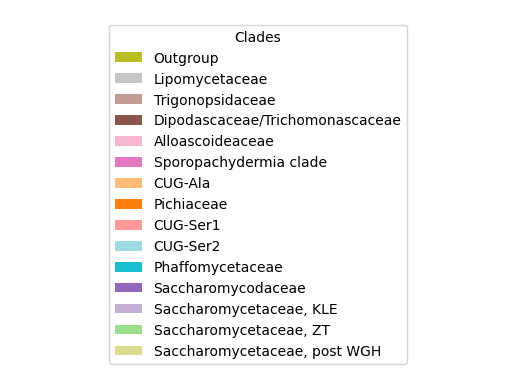

In [125]:
fig,ax = plt.subplots()
legend_elements = [Patch(facecolor=clade_color_lookup[clade], label=clade) for clade in clade_order_curated] 
ax.legend(handles=legend_elements, loc='center', title='Clades')
ax.set_axis_off()
fig.savefig(base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection_legend.svg'))

In [32]:
#Make Tree for experimental species

species_set = pd.read_csv(os.path.normpath(base_dir + '/alphafold/selected_proteins/species_selection/species_selection.csv'), index_col = 0)
species_set_exp = species_set.loc[species_set['Experimental_data_used']=='Y']

spec_id_map = {}
spec_abbrev_lookup = {}
time_tree_names = []
for spec_fullname, (time_tree_name, jacobs_name, spec_orig, spec_abbrev,spec_abbrev_2, spec_og_id, alphafold_structures,long_read_flag, experimental_data, experimental_data_used, clade, load_flag, uniprot, cug_usage, notes, seq_source_af, uniprot_genome) in species_set_exp.iterrows():
    y1000_spec_lookup = y1000_species[y1000_species['original_genome_id']==spec_orig]
    clade_true = y1000_spec_lookup['Major clade'].values[0]
    assert clade_true==clade, 'Clade mismatch: {}, true spelling: {}, bad spelling: {}'.format(spec_fullname, clade_true, clade)
    spec_id = y1000_spec_lookup['spec_og_id'].values[0]
    assert spec_og_id == spec_id, 'OG id mismatch: {}, from species selection table: {}, from original database: {}'.format(spec_fullname, spec_og_id, spec_id)
    spec_id_map[int(spec_og_id)] = spec_orig
    spec_abbrev_lookup[time_tree_name] = spec_abbrev_2
    time_tree_names.append(time_tree_name)

In [31]:
spec_id_map

{110: 'saccharomyces_cerevisiae',
 139: 'wickerhamomyces_anomalus',
 64: 'lachancea_thermotolerans',
 51: 'kluyveromyces_marxianus',
 342: 'zygosaccharomyces_rouxii',
 12: 'candida_albicans',
 30: 'candida_tropicalis',
 50: 'kluyveromyces_lactis',
 52: 'komagataella_pastoris'}

Komagataella_pastoris
Candida_tropicalis
Candida_albicans
Wickerhamomyces_anomalus
Saccharomyces_cerevisiae
Zygosaccharomyces_rouxii
Lachancea_thermotolerans
Kluyveromyces_marxianus
Kluyveromyces_lactis


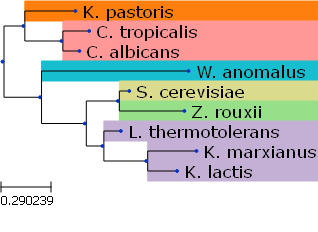

In [34]:
tree_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/shen_2018_data/data_in_Figure2/332_2408OGs_time-calibrated_phylogeny_species-names_updated.newick')
t = Tree(tree_fname)

t.prune(time_tree_names)

#clade_color_lookup = y1000plus_tools.y1000_clade_color_lookup(y1000_species_fname =y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"))
clade_lookup = dict(zip(species_set_exp['Time_tree_name'], species_set_exp['Major clade']))
tab20_cmap = cm.tab20

#get_clade_order
clade_order = []
for jj, node in enumerate(t.get_leaves()):
    clade = clade_lookup[node.name]
    if not(clade in clade_order):
        clade_order.append(clade)

#clade_color_lookup = {clade:colors.to_hex(tab20_cmap(11-jj)) for (jj,clade) in enumerate(clade_order)}

clade_order_curated = clade_order.copy()
clade_order_curated.remove('Saccharomycetaceae')
clade_order_curated = ['Outgroup'] + clade_order_curated + ['Saccharomycetaceae, KLE', 'Saccharomycetaceae, ZT', 'Saccharomycetaceae, post WGH']

clade_color_lookup = {'Outgroup': colors.to_hex(tab20_cmap(15)), 
                      'Lipomycetaceae': colors.to_hex(tab20_cmap(14)),
                      'Trigonopsidaceae': colors.to_hex(tab20_cmap(11)),
                      'Dipodascaceae/Trichomonascaceae': colors.to_hex(tab20_cmap(10)),
                      'Alloascoideaceae': colors.to_hex(tab20_cmap(13)),
                      'Sporopachydermia clade': colors.to_hex(tab20_cmap(12)),
                      'CUG-Ala': colors.to_hex(tab20_cmap(3)),
                      'Pichiaceae': colors.to_hex(tab20_cmap(2)),
                      'CUG-Ser1': colors.to_hex(tab20_cmap(7)),
                      'CUG-Ser2': colors.to_hex(tab20_cmap(19)),
                      'Phaffomycetaceae': colors.to_hex(tab20_cmap(18)),
                      'Saccharomycodaceae': colors.to_hex(tab20_cmap(8)),
                      'Saccharomycetaceae, KLE': colors.to_hex(tab20_cmap(9)),
                      'Saccharomycetaceae, ZT': colors.to_hex(tab20_cmap(5)),
                      'Saccharomycetaceae, post WGH': colors.to_hex(tab20_cmap(17))
                     }



t.ladderize()

# #write file without S. pombe to a newick tree 
# outfile=base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection.nw')
# t.write(outfile)
# t_text = t.write()

# #Add pombe to the tree: 
# t_pombe_text = '(Schizosaccharomyces_pombe:' + str(pombe_branch_len) + ',' + t_text.split(';')[0] + ');'
# t_pombe = y1000plus_tools.Tree(t_pombe_text)
# outfile_pombe=base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection_pombe.nw')
# t_pombe.write(outfile_pombe)

for node in t.get_leaves():
    name = node.name
    print(name)
    #group, abbrev = leaves_to_view[name]
    nstyle = NodeStyle()
    
#     if name=='Schizosaccharomyces_pombe': 
#         clade = 'Outgroup'
        
#         #make red dashes for node line
#         nstyle["hz_line_color"] = "#ff0000"
#         nstyle["hz_line_type"] = 1
#         nstyle["hz_line_width"] = 2.4
        
    #else: 
    clade = clade_lookup[node.name]
    if clade=='Saccharomycetaceae':
        if name in ['Kluyveromyces_lactis','Kluyveromyces_marxianus', 'Lachancea_thermotolerans','Eremothecium_gossypii']: 
            clade = 'Saccharomycetaceae, KLE'
        elif name in ['Zygosaccharomyces_rouxii','Torulaspora_delbrueckii']:
            clade = 'Saccharomycetaceae, ZT'
        elif name in ['Saccharomyces_cerevisiae','Kazachstania_naganishii', 'Vanderwaltozyma_polyspora']: 
            clade = 'Saccharomycetaceae, post WGH'
    #node_color = clade_color_lookup[clade]   shen et al node colors - too bright
    node_color = clade_color_lookup[clade]
    nstyle['bgcolor']= node_color
    
    
    node.set_style(nstyle)
    
    node_label_face = TextFace(' ' + spec_abbrev_lookup[name]) # + " ({})".format(abbrev)) #, fsize=16, fgcolor="black")
    node.add_face(node_label_face, column=1, position = "branch-right")

ts = TreeStyle()
ts.show_leaf_name = False
    
fname = base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/species_selection/species_selection_experimental.svg')
t.render(fname, tree_style=ts)
t.render('%%inline', tree_style=ts)

In [ ]:

# For a given set of species, and a given orthogroup, extract orthogroup genes

og_out_data = {}  # (N_genes, pct_present, og_genes_out)

for og_in in og_set: 

    with open(orthogroup_fname, 'r') as f: 
        for line in f: 
            og_genes = line.split()
            og = og_genes[0].strip(':')

            if og==og_in: 
                genes = og_genes[1:]
                og_genes_out = []
                for gene in genes: 
                    spec_id = gene.split('_')[0]
                    if spec_id in spec_ids: 
                        og_genes_out.append(gene)

    
    #Calculate the percentage of species contained in the orthogroup.
    og_genes_out_specs = [og_gene.split('_')[0] for og_gene in og_genes_out]
    pct_present = len(set(og_genes_out_specs))/len(spec_ids)

    #Extract Fastas for the orthogroups.  
    
    og_out_data[og_in] = (len(og_genes_out), pct_present, og_genes_out)


# Save og_out_data
og_unfiltered_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes_unfiltered.json'

with open(og_unfiltered_fname, 'w') as f:
    json.dump(og_out_data, f, sort_keys=True, indent=4 )

In [ ]:
#Load og_out_data
og_unfiltered_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes_unfiltered.json'
with open(og_unfiltered_fname, 'r') as f:
    og_out_data = json.load(f) 

In [ ]:
pct_present_list = []
#pct_present_thresh = 0.4
og_out_data_filt = {}
total_genes = 0
for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
    pct_present_list.append(pct_present)
    if pct_present > pct_present_thresh: 
        og_out_data_filt[og] = (N_genes, pct_present, og_genes_out)
        total_genes = total_genes + N_genes
        
print('{} total genes in {} orthogroups'.format(total_genes, len(og_out_data_filt)))

# Save filtered og_out_data

og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes.json'

with open(og_fname, 'w') as f:
    json.dump(og_out_data_filt, f, sort_keys=True, indent=4 )

In [ ]:
#Load og_out_data_filt
og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes.json'
with open(og_fname, 'r') as f:
    og_out_data_filt = json.load(f) 

In [ ]:
#Make fastas for all proteins without filtering out S. cer and C. albicans using shen genomes.  
fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + 'all_proteins.fasta'

source = 'shen_2018'

#lists of gene_full names for each species
gene_full_sets = {}

with open(fasta_out_fname, 'w') as f_out: 

    #for each species: 
    for spec_id, spec_name in spec_id_map.items(): 

        spec = spec_id_map[spec_id]

        spec_orig_genome = spec_orig_genome_lookup[spec_id]
        
        if spec_orig_genome == 'saccharomyces_cerevisiae':
            protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Saccharomyces_cerevisiae_S288C_protein.fasta')
        elif spec_orig_genome == 'candida_albicans': 
            protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Candida_albicans_SC5314_A22_current_default_protein.fasta')
        else: 
            protein_fname = protein_dir + spec_orig_genome + '.max.pep'
        seq_records = SeqIO.parse(protein_fname, "fasta")
        
        spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')

        spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)
        
        if spec_orig_genome == 'saccharomyces_cerevisiae':
            #for S. cerevisiae the orf name is the 'gene_full'
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
        else: 
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

        
        
        #for each orthogroup:
        #extract protein seq if it comes from the right species.
        
        #gene_full: (y1000_id, og)
        seqs_to_get = {}
        gene_full_set = []
        for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
            for y1000_id in og_genes_out: 
                spec_id_check = int(y1000_id.split('_')[0])
                if spec_id_check==spec_id:
                    gene_full = gene_full_y1000_id_lookup[y1000_id]
                    seqs_to_get[gene_full] = (y1000_id, og)
                    gene_full_set.append(gene_full)
        
        gene_full_sets[spec_orig_genome] = gene_full_set
        
        for seq_record in seq_records:
            #gene_full = 'augustus_masked-Deha2C-processed-gene-4.36'
            if spec_orig_genome == 'saccharomyces_cerevisiae':
                gene_full_check = seq_record.description.split()[0] #SC specific
            elif spec_orig_genome == 'candida_albicans': 
                gene_full_check = seq_record.description
            else: 
                gene_full_check = seq_record.description.split()[1].split('=')[1]
            #print(gene_full)
            if (gene_full_check in gene_full_set):
                ##find which y1000_id was matched
                #y1000_rlookup = genes_lookup['gene_full'] == gene_full
        #         for gene, tf in y1000_rlookup.items(): 
        #             if tf:
        #                 y1000_id=gene
        #         gene_id = genes_lookup.loc[y1000_id, 'gene_id']
                
                (y1000_id, og) = seqs_to_get[gene_full_check]
                protein_seq = seq_record.seq
                f_out.write('>' + spec_orig_genome + '__' + og + '__' + y1000_id + ' gene_full=' + gene_full_check +
                        ' source=' + source + '\n')
                f_out.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case





In [ ]:
# #Find matches comparing shen and uniprot proteome. 

# #Only need to redo this if you are re-calculating pairwise_scores

# shen_proteome_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 
# uniprot_proteome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/diverse_yeast/proteomes') + os.sep 

# #(orig_genome ame: (shen_fname, uniprot_fname)): 
# proteome_fasta_dict = {'kluyveromyces_lactis': {'shen': shen_proteome_dir + 'kluyveromyces_lactis.max.pep', 
#                                                 'uniprot': uniprot_proteome_dir + 'Klac_uniprot-proteome_UP000000598.fasta'
#                                                }, 
#                        'wickerhamomyces_anomalus': {'shen': shen_proteome_dir + 'wickerhamomyces_anomalus.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Wano_uniprot-proteome_UP000094112.fasta'
#                            }, 
#                        'lachancea_thermotolerans': {'shen': shen_proteome_dir + 'lachancea_thermotolerans.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Lthe_uniprot-proteome_UP000002036.fasta'
#                            }, 
#                        'komagataella_pastoris': {'shen': shen_proteome_dir + 'komagataella_pastoris.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Kpas_uniprot-proteome_UP000000314.fasta'
#                            }, 
#                         'candida_tropicalis': {'shen': shen_proteome_dir + 'candida_tropicalis.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Ctro_uniprot-proteome_UP000002037.fasta'
#                            },
#                         'debaryomyces_hansenii': {'shen': shen_proteome_dir + 'debaryomyces_hansenii.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Dhan_uniprot-proteome_UP000000599.fasta'
#                            }, 
#                         'yHMPu5000034957_hanseniaspora_osmophila_160519': {'shen': shen_proteome_dir + 'yHMPu5000034957_hanseniaspora_osmophila_160519.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Hosm_uniprot-proteome_UP000095728.fasta'
#                            }, 
#                         'kluyveromyces_marxianus': {'shen': shen_proteome_dir + 'kluyveromyces_marxianus.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Kmar_uniprot-proteome_UP000065495.fasta'
#                            }, 
#                         'zygosaccharomyces_rouxii': {'shen': shen_proteome_dir + 'zygosaccharomyces_rouxii.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Zrou_uniprot-proteome_UP000008536.fasta'
#                            }
#                       }

# study1 = 'shen'
# study2 = 'uniprot'

# match_points = 1
# mismatch_points = -1
# gap_open = -.5
# gap_extension = -0.1
# NN_top_scores = 5
# penalize_end_gaps = True 


# pairwise_scores = {}
# spec_orig_genomes = list[proteome_fasta_dict.keys()]#[ 'yHMPu5000034957_hanseniaspora_osmophila_160519']  #'zygosaccharomyces_rouxii','kluyveromyces_marxianus','candida_tropicalis', 'debaryomyces_hansenii',

# for spec_orig_genome in spec_orig_genomes:
#     print(spec_orig_genome)
#     #spec_orig_genome = 'komagataella_pastoris'# 'lachancea_thermotolerans' #'wickerhamomyces_anomalus' # 'kluyveromyces_lactis'

#     use_subset = True
#     subset = set(gene_full_sets[spec_orig_genome])
#     pairwise_score_loaded = False #if you have already saved some and want to do the rest

#     # #Check timing with time module
#     # #python parallel programming library
#     # #ipy_parallel dask
#     # #https://ipyparallel.readthedocs.io/en/stable/development/messages.html#parallel-messages

#     # #All by all pairwise sequence alignment, output top NN results

#     genenames_study1 = []
#     AA_seqs_study1 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study1], "fasta")
#     for seq_study1 in AA_seqs_study1: 
#         genename_study1 = dyt.gene_id_retrieve(study1, seq_study1)
#     #     if spec=='Smik': 
#     #         genename_study1_dash = genename_study1
#     #         genename_study1 = 'smik' + genename_study1_dash.split('smik_')[1]
#         genenames_study1.append(genename_study1)

#     if use_subset: 
#         print('Using Subset genes')
#     else: 
#         subset = set(genenames_study1)

#     if pairwise_score_loaded: 
#         genes_to_search = ((subset & set(genenames_study1)) - set(pairwise_score.keys()))
#     else: 
#         pairwise_score = {}
#         genes_to_search = (subset & set(genenames_study1))


#     AA_seqs_study1 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study1], "fasta")


#     N = len(genes_to_search)
#     for seq_study1 in AA_seqs_study1: 
#         check_gene = False
#         genename_study1 = dyt.gene_id_retrieve(study1, seq_study1)
#     #     if spec=='Smik': 
#     #         genename_study1_dash = genename_study1
#     #         genename_study1 = 'smik' + genename_study1_dash.split('smik_')[1]
#         if genename_study1 in genes_to_search:
#             check_gene = True

#         if check_gene: 
#             print(str(N) + ' ' + genename_study1)
#             AA_seqs_study2 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study2], "fasta")
#             pairwise_score_comps = {}
#             for seq_study2 in AA_seqs_study2: 
#                 genename_study2 = seq_study2.id
#                 score = pairwise2.align.globalms(seq_study2,seq_study1, match_points, mismatch_points, gap_open, gap_extension, penalize_end_gaps = penalize_end_gaps, score_only = True )
#                 pairwise_score_comps[genename_study2] = score
#             pairwise_score_comps_df = pd.Series(pairwise_score_comps)
#             pairwise_score[genename_study1] = pairwise_score_comps_df.sort_values(ascending=False).iloc[0:NN_top_scores]
#             #print(pairwise_score[genename_YGOB])
#             N = N - 1

#     pairwise_scores[spec_orig_genome] =  pairwise_score

In [ ]:
##Load pairwise scores

pairwise_scores_fname = base_dir + os.sep + 'alphafold' + os.sep + 'pairwise_scores.pkl'

# # Save pairwise_scores
# with open(pairwise_scores_fname, 'wb') as f:
#     pickle.dump(pairwise_scores, f)

# Load pairwise_scores
with open(pairwise_scores_fname, 'rb') as f: 
    pairwise_scores = pickle.load(f)

In [ ]:
## Show histogram of the pairwise scores and use it to choose thresholds: 

fig, axarr = plt.subplots(3,3, figsize=(15,15))

#pairwise_scores = {}
#for jj, spec in enumerate(['Ncas','Klac','Smik']):

#pairwise_score_fname = data_processing_dir + os.path.normpath("ortholog_files_YGOB/AA_lists/" + spec + "_pairwise_score.pkl")

#with open(pairwise_score_fname,'rb') as file: 
#    pairwise_score= pickle.load(file)

#pairwise_scores[spec] = pairwise_score
#Use histogram to choose thresholds

for jj, (spec_orig_genome, pairwise_score) in enumerate(pairwise_scores.items()):
    ax = axarr.flatten()[jj]
    maxvals = []
    diff_top2 = []
    for genename_shen, options in pairwise_score.items(): 
        options_sorted = options.sort_values()
        #idxmax = options.idxmax()
        maxval = options_sorted[-1]
        diff_top2_val = maxval-options_sorted[-2]
        diff_top2.append(diff_top2_val)
        maxvals.append(maxval)
        #if maxval<90: 
        #if (maxval>90) & (diff_top2_val<20):
        #   print('{}, maxval: {}, difference: {}'.format(genename_shen,maxval,diff_top2_val))

    
    ax.scatter(maxvals, diff_top2)
    ax.set_title(spec_orig_genome)
    ax.set_xlabel('maximum similarity')
    ax.set_ylabel('difference between top 2')
    #ax.set_title(spec)

In [ ]:
# if genome_name == 'saccharomyces_cerevisiae':
#     #load gene_id map based on the species
#     gene_lookup_spec_fname = y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/id_lookups/" + genome_name + '.csv')
#     gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

#     protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Saccharomyces_cerevisiae_S288C_protein.fasta')

#     seq_records = SeqIO.parse(protein_fname, "fasta")

#     genes_lookup = gene_lookup_spec.loc[genes]
#     genes_lookup_set = set(gene_lookup_spec.loc[genes,'gene_id'].values)  #SC specific

#     for seq_record in seq_records:
#         gene_id = seq_record.description.split()[0] #SC specific
#         #print(gene_full)
#         if (gene_id in genes_lookup_set):
#             #find which y1000_id was matched
#             y1000_rlookup = (genes_lookup['gene_id'] == gene_id)
#             for gene, tf in y1000_rlookup.items(): 
#                 if tf:
#                     y1000_id=gene
#             protein_seq = seq_record.seq
#             f.write('>' + genome_name + '_' + gene_id + ' y1000_id=' + y1000_id + ' gene_id=' + gene_id +
#                     ' common_name=' + seq_record.description.split()[1] + #this adds in the cds from the original description
#                     '\n')
#             f.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case

In [ ]:
# Get Orthogroup metadata
#Cycle through each protein. 

#Record Metadata

#OG Metadata: 
# SC Genenames, SP genenames, CA genenames
# Total number
# Percent of species covered
#Possible future
# Pathways
# Enzyme numbers

#{og: N_genes, pct_spec, og_genes, pathways, enzyme_numbers, sc_genenames, sc_names, sp_genename, ca_genename}

scer_spec_id = 110

#Build lookup table from S. pombe to S. cerevisiae
sp_orth_map_fname = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/spom/cerevisiae-orthologs.txt')
sp_orth_map = pd.read_table(sp_orth_map_fname, skiprows=1, header=None, names=['Spom','Scer'])
scer_spom_lookup = {}
none_list = []
for row, (spom_gene, scer_genes) in sp_orth_map.iterrows():
    if scer_genes=='NONE': 
        none_list.append(spom_gene)
    else:
        scer_genes_list = scer_genes.split('|')
        for scer_gene in scer_genes_list: 
            scer_spom_lookup[scer_gene] = spom_gene

#build C. albicans lookup table 
ca_orth_map_fname = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/calb/C_albicans_SC5314_S_cerevisiae_orthologs.txt')
ca_orth_map = pd.read_table(ca_orth_map_fname, skiprows=8, header=None, names = ['cg_name', 'cgd_id', 'sc_genename', 'sc_name', 'sgd_id']) #, names=['Spom','Scer'])
scer_calb_lookup = dict(zip(ca_orth_map['sc_genename'], ca_orth_map.index))

            
            
og_out_data_full = {}
jj = 0
for (og, (N_genes, pct_spec, og_genes)) in og_out_data.items():
    #print(og + ' ' + str(jj))
    og_out_data_full_item = {}
    og_out_data_full_item['N_genes'] = N_genes
    og_out_data_full_item['pct_spec'] = pct_spec
    og_out_data_full_item['og_genes'] = og_genes
    if  pct_spec>pct_present_thresh:
        og_out_data_full_item['pass_species_filter'] = True
    else: 
        og_metadata_full_item['pass_species_filter'] = False
        
    #get_sc_genes
    sc_genes = []
    for og_gene in og_genes: 
        spec_id_check = int(og_gene.split('_')[0])
        if spec_id_check==scer_spec_id:
            sc_genes.append(scer_y1000_id_gene_id_lookup[og_gene])
    
    #get pathway and EC annotations
    og_out_data_full_item['sc_genes'] = sc_genes
    og_out_data_full_item['sc_names'] = yeast_esr_exp.SC_common_name_lookup(sc_genes)
    og_out_data_full_item['pathways_id'] = list(sc_annotations_orf.loc[sc_genes]['Gene.pathways.identifier'])
    og_out_data_full_item['pathways_name'] = list(sc_annotations_orf.loc[sc_genes]['Gene.pathways.name'])
    og_out_data_full_item['EC_number'] = list(sc_annotations_orf.loc[sc_genes]['EC number'])
    og_out_data_full_item['PDB_ID'] = list(sc_annotations_orf.loc[sc_genes]['PDB ID'])  #Need to convert NaN in these to 'NULL' to work with R's JSON import also see https://jsonlint.com/
    
    #get sp_genes
    sp_genes = []
    ca_genes = []
    for sc_gene in sc_genes: 
        if sc_gene in scer_spom_lookup.keys(): 
            sp_genes.append(scer_spom_lookup[sc_gene])
        else: 
            sp_genes.append('NONE')
        
        if sc_gene in scer_calb_lookup.keys(): 
            ca_genes.append(scer_calb_lookup[sc_gene])
        else: 
            ca_genes.append('NONE')
    
    og_out_data_full_item['spom_genes'] = sp_genes
    og_out_data_full_item['calb_genes'] = ca_genes
    
    
    og_out_data_full[og] = og_out_data_full_item
    jj = jj + 1




In [ ]:
# Save og_out_data_full (or metadata file)
og_out_data_full_fname = base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins' + os.sep + 'og_metadata.json'

with open(og_out_data_full_fname, 'w') as f:
    json.dump(og_out_data_full, f, indent=4 )

In [55]:
#Load og_out_data_filt
og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins' + os.sep +  'og_metadata.json'
with open(og_fname, 'r') as f:
    og_out_data_full = json.load(f) 

In [59]:
#How many Orthogroups did we keep?

#How many pathways did that cover?


kept_ogs = []
kept_pathways = []
for og, og_metadata_dict in og_out_data_full.items(): 
    if og_metadata_dict['pass_species_filter']: 
        kept_ogs.append(og)
        kept_pathway_list = og_metadata_dict['pathways_name']
        for kept_pathway_list_paralog in kept_pathway_list: 
            kept_pathway_list_paralog_clean = ast.literal_eval(kept_pathway_list_paralog)
            for kept_pathway in kept_pathway_list_paralog_clean:
                kept_pathways.append(kept_pathway)

kept_pathway_list_unique = set(kept_pathways)

#total pathways
pathway_list = []
#Note: need to use ast.literal_eval because the strip/split method didn't work - too many commas in the names I suspect. 
for gene, pathway_names in sc_annotations_pway_subset['Gene.pathways.name'].iteritems():
    pathway_names_clean = ast.literal_eval(pathway_names)
    for pathway_name in pathway_names_clean: 
        pathway_list.append(pathway_name)

pathway_list_unique = set(pathway_list)
                
print(str(len(kept_ogs)) + ' orthogroups left that passed the species filter')

print('{} of {} pathways kept = {:%}'.format(len(kept_pathway_list_unique),len(pathway_list_unique), len(kept_pathway_list_unique)/len(pathway_list_unique)))


426 orthogroups left that passed the species filter
173 of 173 pathways kept = 100.000000%


In [ ]:
### Rebuild selected_proteins to fix source issue. 

In [ ]:
#Build Fasta file

fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins.fasta'

#the following information is in the fasta header for each protein
#<spec_orig_genome>__<og>__<y1000_id>: you can use this to look up other metadata in the og_metadata.json file
#source:  The source of the peptide sequence (either 'shen' or 'uniprot')
#gene_full:  The full name of the gene from source peptide file
#gene_full_shen: the full name of the gene from the shen peptide file
#L: Length of the gene
#sim_score_vs_shen: The similarity score between the shen peptide sequence and the uniprot peptide sequence.  If it is above the threshold, the uniprot sequence is used, below the threshold, we continue to use the shen sequence
#sim_score_vs_shen_diff: The difference between similarity score of the top peptide and the second highest scoring peptide.  For genes with similarity score below a threshold, if this difference is too small, we keep the shen sequence

shen_proteome_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 
uniprot_proteome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/diverse_yeast/proteomes') + os.sep 

#(species genome name: (shen_fname, uniprot_fname)): 
proteome_fasta_dict = {'kluyveromyces_lactis': {'shen': shen_proteome_dir + 'kluyveromyces_lactis.max.pep', 
                                                'uniprot': uniprot_proteome_dir + 'Klac_uniprot-proteome_UP000000598.fasta'
                                               }, 
                       'wickerhamomyces_anomalus': {'shen': shen_proteome_dir + 'wickerhamomyces_anomalus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Wano_uniprot-proteome_UP000094112.fasta'
                           }, 
                       'lachancea_thermotolerans': {'shen': shen_proteome_dir + 'lachancea_thermotolerans.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Lthe_uniprot-proteome_UP000002036.fasta'
                           }, 
                       'komagataella_pastoris': {'shen': shen_proteome_dir + 'komagataella_pastoris.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kpas_uniprot-proteome_UP000000314.fasta'
                           }, 
                        'candida_tropicalis': {'shen': shen_proteome_dir + 'candida_tropicalis.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Ctro_uniprot-proteome_UP000002037.fasta'
                           },
                        'debaryomyces_hansenii': {'shen': shen_proteome_dir + 'debaryomyces_hansenii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Dhan_uniprot-proteome_UP000000599.fasta'
                           }, 
                        'yHMPu5000034957_hanseniaspora_osmophila_160519': {'shen': shen_proteome_dir + 'yHMPu5000034957_hanseniaspora_osmophila_160519.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Hosm_uniprot-proteome_UP000095728.fasta'
                           }, 
                        'kluyveromyces_marxianus': {'shen': shen_proteome_dir + 'kluyveromyces_marxianus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kmar_uniprot-proteome_UP000065495.fasta'
                           }, 
                        'zygosaccharomyces_rouxii': {'shen': shen_proteome_dir + 'zygosaccharomyces_rouxii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Zrou_uniprot-proteome_UP000008536.fasta'
                           }
                      }


sim_score_high_thresh = 75
sim_score_low_thresh = 60
sim_score_diff_thresh = 8


with open(fasta_out_fname, 'w') as f_out: 

    #for each species: 
    for spec_id, spec_orig_genome in spec_id_map.items(): 
        
        #spec_orig_genome = spec_orig_genome_lookup[spec_id]
        print(spec_orig_genome)
        
        if spec_orig_genome in {'saccharomyces_cerevisiae', 'candida_albicans', 'schizosaccharomyces_pombe'}: 
            print('skipping ' + spec_orig_genome)
            #Skip this species
        elif spec_orig_genome in proteome_fasta_dict.keys():
            #Attempt to convert to uniprot fasta  
            print('checking to see if uniprot or shen et al sequences should be used')
            source = 'uniprot'
            
            protein_fname_uniprot = proteome_fasta_dict[spec_orig_genome]['uniprot']
            seq_records_uniprot = SeqIO.parse(protein_fname_uniprot, "fasta")
            pairwise_scores_spec = pairwise_scores[spec_orig_genome]
            
            protein_fname_shen = proteome_fasta_dict[spec_orig_genome]['shen']
            seq_records_shen = SeqIO.parse(protein_fname_shen, "fasta")
        
            spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')
            spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)

#             if spec_orig_genome == 'saccharomyces_cerevisiae':
#                 #for S. cerevisiae the orf name is the 'gene_full'
#                 gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
#             else: 
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

            #for each orthogroup:
            #Identify whether the proteins will be uniprot or shen 
            seqs_to_get_uniprot = {} #gene_full_uniprot: (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
            seqs_to_get_shen = {}  #gene_full_shen: (y1000_id, og, maxval, diff_top2_val)
            gene_full_set_uniprot = []
            gene_full_set_shen = []
            for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
                for y1000_id in og_genes_out: 
                    spec_id_check = int(y1000_id.split('_')[0])
                    if spec_id_check==spec_id:
                        gene_full_shen = gene_full_y1000_id_lookup[y1000_id]
                        pairwise_score_gene = pairwise_scores_spec[gene_full_shen]
                        
                        #Check to see if pairwise scores pass filters: 
                        options_sorted = pairwise_score_gene.sort_values(ascending=False)  #possible that they are already sorted and this is unnecessary
                        maxval = options_sorted[0]
                        diff_top2_val = maxval-options_sorted[1]
                        
                        if ((maxval>sim_score_high_thresh) | ((maxval>sim_score_low_thresh) & (diff_top2_val>sim_score_diff_thresh))): 
                            gene_full_uniprot = options_sorted.index[0]
                            seqs_to_get_uniprot[gene_full_uniprot] = (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
                            gene_full_set_uniprot.append(gene_full_uniprot)
                        else: 
                            seqs_to_get_shen[gene_full_shen] = (y1000_id, og, maxval, diff_top2_val)
                            gene_full_set_shen.append(gene_full_shen)
                                      
            #Cycle through uniprot proteome and print to fasta if it is in the set. 
            dyt.seq_record_fasta_printout(seq_records_uniprot, f_out, gene_full_set_uniprot, seqs_to_get_uniprot, 'uniprot', spec_orig_genome)
                 
            #Cycle through shen proteome and print to fasta if it is in the set. 
            dyt.seq_record_fasta_printout(seq_records_shen, f_out, gene_full_set_shen, seqs_to_get_shen, 'shen', spec_orig_genome)

        
        
        else: 
            print('using shen et al sequence')
            dyt.fasta_extract_shen(f_out,shen_proteome_dir, spec_orig_genome, y1000plus_dir, og_out_data, spec_id)


## Control peptide files





In [ ]:
#Control peptides are 
#CDC19/PYK2
#ERG11

#These are already made in 20210826_met_orths
#MET17
#STE2/HSU1
#IRC7
#STR3
#YH112C
#CYS3

y1000_species_subset = y1000_species[y1000_species['Major clade']!='outgroup']

# y1000_plus_dir_ubuntu = '/home/heineike/GitHub/y1000plus_tools/data/'
# metproj_data_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/projects/jason_met_auxotrophy') + os.sep

# aln_fname_base_win = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/proteins_og') + os.sep

#Select only clades of interest: 
#clades_of_interest = {'Saccharomycetaceae','Saccharomycodaceae','Phaffomycetaceae','CUG-Ser2','CUG-Ser1','Pichiaceae','CUG-Ala'}
#clades_of_interest = {'Saccharomycetaceae', 'Saccharomycodaceae'}
#outgroups = [ 'Wickerhamomyces anomalus','Cyberlindnera jadinii', 'Ascoidea rubescens','Komagataella pastoris','Debaryomyces hansenii', 'Candida albicans', 'Yarrowia lipolytica']
#outgroup = 'Yarrowia lipolytica'




#Met17: 'YLR303W', 
#Str2:  YJR130C
#'YML082W', 
#Str3: 'YGL184C', 
#'YLL058W', 
#Cys3: 'YAL012W'
#IRC7: 'YFR055W'


#target_y1000_ids = scer_lookup.loc[['YLR303W', 'YML082W','YJR130C', 'YFR055W', 'YHR112C', 'YGL184C', 'YLL058W', 'YAL012W'], 'y1000_id']
gois = ['CDC19', 'PYK2', 'ERG11', 'STR2']
target_y1000_ids = scer_lookup.loc[yeast_esr_exp.SC_orf_lookup_by_name(gois), 'y1000_id']

gois_y1000_id_lookup = dict(zip(gois, target_y1000_ids))


y1000_id_list = list(target_y1000_ids)
goi_og_lookup, og_genes_lookup = y1000plus_tools.make_og_genes_lookup(y1000_id_list, y1000_species_subset)



In [ ]:
gois_y1000_id_lookup['CDC19']

In [ ]:
gois_y1000_id_lookup

In [ ]:
goi_og_lookup

In [ ]:
target_y1000_ids

In [ ]:
og_mapping = {'CDC19_PYK2': goi_og_lookup[gois_y1000_id_lookup['CDC19']],
              'ERG11': goi_og_lookup[gois_y1000_id_lookup['ERG11']], 
              'STR2_HSU1':  goi_og_lookup[gois_y1000_id_lookup['STR2']]
             }
og_mapping

In [ ]:
#Only need to do once

for protein_fname, og in og_mapping.items():
    og_genes = og_genes_lookup[og]
    y1000plus_tools.extract_protein_seqs(og_genes, protein_fname, y1000_species_subset)
    print(protein_fname + ' protein sequence extraction complete')

In [ ]:
## Make control JSON files to pass to jacob

In [ ]:
#Load og_out_data_full
og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'
with open(og_fname, 'r') as f:
    og_out_data_full = json.load(f) 

In [ ]:
og_out_data_control = {}

for protein_fname, og in og_mapping.items():
    og_out_data_og = og_out_data_full[og]
    og_genes = og_genes_lookup[og]
    og_out_data_og['og_genes']=list(og_genes)
    og_out_data_og['N_genes'] = len(og_genes)
    
    
    del og_out_data_og['pct_spec']
    del og_out_data_og['pass_species_filter']
    og_out_data_control[og] = og_out_data_og
    
# Save og_out_data
og_out_data_control_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes_control.json'

with open(og_out_data_control_fname, 'w') as f:
    json.dump(og_out_data_control, f, sort_keys=True, indent=4 )

#Possible fields include: 

N_genes: Number of genes in orthogroup
og_genes: List of identifiers of genes in orthogroup from [1]
sc_genes: Systematic name of S. cerevisiae genes present in orthogroup
sc_names: Common Name of S. cerevisiae genes present in orthogroup
pathways_id: Id number of pathways for each gene from S. cerevisiae
pathways_name: Name of pathway for each gene from S. cerevisiae
EC_number: EC number (if any) for each gene from S. cerevisiae
PDB_ID: PDB ID of structure for each gene from S. cerevisaiae
spom_genes: systematic name of S. pombe ortholog of the S. cerevisiae genes in the orthogroup. Based on Pombase file.
calb_genes: systematic name of C. albicans ortholog of the S. cerevisiae genes in the orthogroup. Based on CGD file.

Removed: 
pass_species_filter: true or false depending on whether pct_spec is above the threshold (currently 0.4)
pct_spec: percentage of species from our species selection that are represented in the orthogroup



    

In [ ]:
#Load 25 species og mapping

#Read in orthogroup listing from orthomcl.txt

#Count og_genes and add in N_genes

#Reset N_genes
#Remove pct_spec, pass_species_filter

#Add in new og_genes list.  

In [ ]:
og_mapping = {'CDC19_PYK2': goi_og_lookup[gois_y1000_id_lookup['CDC19']],
              'ERG11': goi_og_lookup[gois_y1000_id_lookup['ERG11']], 
              'STR2_HSU1':  goi_og_lookup[gois_y1000_id_lookup['STR2']]
             }

## 03 Feb 2022 Sandra noticed duplicate IDs in the protein file
# I found the bug (was naming proteins with gene_full instead of gene_full_check), remade the files and sent her the corrected ones.  

In [ ]:
## 03 Feb 2022 Sandra noticed duplicate IDs in the protein file
# I found the bug (was naming proteins with gene_full instead of gene_full_check), remade the files and sent her the corrected ones.  

selected_fasta = base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins.fasta'
all_fasta = base_dir + os.sep + 'alphafold' + os.sep + 'all_proteins.fasta'
cont_fasta = base_dir + os.sep + 'alphafold' + os.sep + 'STR2_YLL058W.fasta'

seq_records_sel = SeqIO.parse(selected_fasta, "fasta")
seq_records_all = SeqIO.parse(all_fasta, "fasta")
seq_records_cont = SeqIO.parse(cont_fasta, "fasta")

In [ ]:
names = []

for record in seq_records_cont: 
    names.append(record.name)

len(set(names))

In [ ]:
len(names)

In [ ]:
#Counter(names).most_common()

#Previously it found the following species had many duplicate ids.  The other species were fine.  The error effected only species that only had shen data: 

# ('alloascoidea_hylecoeti__OG5722__0_7605', 552),
#  ('geotrichum_candidum__OG5722__43_1771', 510),
#  ('vanderwaltozyma_polyspora__OG7278__136_23', 477),
#  ('ascoidea_rubescens__OG5735__6_750', 461),
#  ('kazachstania_naganishii__OG8784__49_4009', 460),
#  ('cyberlindnera_jadinii__OG6065__35_2226', 454),
#  ('yHMPu5000034604_sporopachydermia_lactativora_160519__OG5404__170_5570',
#   450),
#  ('yarrowia_lipolytica__OG5722__144_3506', 447),
#  ('pachysolen_tannophilus__OG5621__106_2089', 445),
#  ('torulaspora_delbrueckii__OG7278__135_3579', 430),
#  ('lipomyces_starkeyi__OG5722__66_8498', 426),
#  ('eremothecium_gossypii__OG7818__40_277', 401),
#  ('ogataea_parapolymorpha__OG5096__104_1849', 397),
#  ('candida_apicola__OG5441__13_3008', 393),
#  ('tortispora_caseinolytica__OG5722__134_2655', 380),

## Generate Pathway list to send to Jacob Steenwyk 20220419

In [ ]:
sc_annotations_df = pd.read_csv(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_annotation_summary_20211007.csv', index_col = 0)

scer_orf_table = pd.read_table(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_orf_list_20211025.tsv', index_col=1, names= ['SGD_id', 'species', 'Name', 'full_name', 'qualifier', 'status'])

scer_orf_table_not_dub = scer_orf_table[scer_orf_table['qualifier'] != 'Dubious']

sc_annotations_orf = sc_annotations_df.loc[list(set(sc_annotations_df.index) & set(scer_orf_table_not_dub.index ))]

sc_annotations_orf['N_pathways'] = [len(ast.literal_eval(pway_list)) for pway_list in sc_annotations_orf['Gene.pathways.name']]

sc_annotations_pway_subset = sc_annotations_orf[sc_annotations_orf['N_pathways']>0]

og_metadata_filtered = {}

for og, metadata in og_metadata.items():
    if metadata['pass_species_filter']: 
        og_metadata_filtered[og] = metadata
        
print('Total ogs in pathways: {}, Ogs that meet species percentage threshold: {}'.format((len(og_metadata.keys())), len(og_metadata_filtered.keys())))

In [ ]:
#make list of all possible pathways
pway_full_list= []

for pway_list in sc_annotations_pway_subset['Gene.pathways.name']:
    pway_list = ast.literal_eval(pway_list)
    for pway in pway_list: 
        pway_full_list.append(pway)

print(len(pway_full_list))

pway_unique_list = list(set(pway_full_list))

print(len(pway_unique_list))
    
# Make dict of all pathways with list of their s_cer genes

pway_genes = {pway: [] for pway in pway_unique_list}

for gene, pway_list in sc_annotations_pway_subset['Gene.pathways.name'].iteritems():
    #print(gene)
    #print(pway_list)
    pway_list = ast.literal_eval(pway_list)
    for pway in pway_list: 
        #print(pway)
#         if pway == 'PWY30-230': 
#             print(gene)
#             print(pway_genes_out)
        pway_genes_out = pway_genes[pway]
        pway_genes_out.append(gene)

        pway_genes[pway] = pway_genes_out


        
# Make data frame from that dict
pway_genes_df = pd.DataFrame(pd.Series(pway_genes))

pway_genes_df.rename(columns = {0:'sc_genes'}, inplace=True)

# Add a column which is the gene name

# Add a column which is a list of whether each gene is present or not in our list
og_metadata_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'


with open(og_metadata_fname, 'r') as f:
    og_metadata = json.load(f) 
    
all_present_genes = []
pct_present_thresh = 0.4

for og in og_metadata.keys():
    if og_metadata[og]['pct_spec']>pct_present_thresh:
        all_present_genes = all_present_genes + og_metadata[og]['sc_genes']

all_present_genes_unique = set(all_present_genes)
print('Number of genes present in orthogroups: {} \nNumber of unique genes present in ortogroups: {}'.format(len(all_present_genes), len(all_present_genes_unique)))


sc_genes_name = []
sc_genes_presence = []
for sc_genes in pway_genes_df['sc_genes']: 
    sc_names = yeast_esr_exp.SC_common_name_lookup(sc_genes)
    sc_genes_name.append(sc_names)
    sc_presence = [sc_gene in all_present_genes_unique for sc_gene in sc_genes]
    sc_genes_presence.append(sc_presence)

pway_genes_df['sc_genes_name'] = sc_genes_name
pway_genes_df['sc_genes_presence'] = sc_genes_presence
pway_genes_df.index.name = 'pathway'
    
#pway_genes_df.to_csv(base_dir + os.sep + 'alphafold' + os.sep + 'pathway_list.tsv', sep = '\t')

# Obtain fasta for Feiran of our S.cer, C.alb, and S.pom proteins of interest

In [ ]:
## Need to get IDs 

In [62]:
#Extract Protein Sequences directly from Oliver's PDB Files

#(metadata_field,ref_status, species)
model_fields = {'Scer': ( 'REF_','saccharomyces_cerevisiae'),
                'Spom': ('','schizosaccharomyces_pombe'),
                'Calb': ('','candida_albicans')
               }
          
pdb_base = base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/pdbs') + os.sep
output_file = base_dir + os.sep + os.path.normpath('alphafold/selected_proteins/selected_proteins_modelorgs.fasta')

swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()
gene_id_2_y1000_id = dyt.load_model_gene_id_2_y1000_id()
model_og_lookup = dyt.load_model_og_lookup()

#Make dictionary to lookup og from geneID in model species. 


with warnings.catch_warnings():
    warnings.simplefilter("ignore")  #There was a warning about headers not existing in the PDBs
    with open(output_file, 'w') as f_out:
        for spec_abbrev, (ref_status, spec) in model_fields.items():
            print(spec_abbrev)
            swissprot_id_2_gene_id_spec = swissprot_id_2_gene_id[spec_abbrev]
            gene_id_2_y1000_id_spec = gene_id_2_y1000_id[spec_abbrev]
            model_og_lookup_spec = model_og_lookup[spec_abbrev]

            pdb_base_spec = pdb_base + 'Alphafold_' + spec_abbrev + '_sel' + os.sep
            for fname in os.listdir(pdb_base_spec):
                swissprot_id = fname.split('-')[1]
                if swissprot_id in swissprot_id_2_gene_id_spec.keys():
                    gene_id = swissprot_id_2_gene_id_spec[swissprot_id]
                    if gene_id in gene_id_2_y1000_id_spec.keys():
                        y1000_id = gene_id_2_y1000_id_spec[gene_id]
                    else: 
                        print('no y1000_id found for ' + swissprot_id + ' in ' + spec_abbrev)
                        y1000_id = 'NONE'

                    assert gene_id in model_og_lookup_spec.keys(), gene_id + ' not in og lookup'

                    og = model_og_lookup_spec[gene_id]


                else: 
                    print('no gene_id for ' + swissprot_id + ' in ' + spec_abbrev)
                    gene_id = 'NONE'
                    y1000_id = 'NONE'

                header = '>' + gene_id + ' og=' + og + ' species=' + spec + ' uniprot_id=' + swissprot_id + ' af2_id=' + ref_status + spec_abbrev + '_' + fname.split('.')[0] + ' y1000_id=' + y1000_id + '\n'
                f_out.write(header)
                pdb_file = SeqIO.parse(pdb_base_spec + fname, "pdb-atom")
                for (jj,record) in enumerate(pdb_file):
                    if jj==0: 
                        f_out.write(str(record.seq) + '\n')    
                    elif jj==1: 
                        print('Why is there more than one record? ' + fname)

Spom: No official name, systematic_id or synonym for matmc_2 y1000_id=121_134
Spom: No official name, systematic_id or synonym for SPCC622.05 y1000_id=121_2159
Spom: No official name, systematic_id or synonym for SPAC4H3.12c y1000_id=121_2282
Spom: No official name, systematic_id or synonym for meu1-1-1 y1000_id=121_2287
Spom: No official name, systematic_id or synonym for sab14 y1000_id=121_2434
Spom: No official name, systematic_id or synonym for SPBC36.13 y1000_id=121_2778
Spom: No official name, systematic_id or synonym for SPAC1F8.09c.1 y1000_id=121_3125
Spom: No official name, systematic_id or synonym for SPBC32F12.17 y1000_id=121_3368
Spom: No official name, systematic_id or synonym for SPBC1685.12c y1000_id=121_3533
Spom: No official name, systematic_id or synonym for SPCC417.04 y1000_id=121_3584
Spom: No official name, systematic_id or synonym for SPMTR.04 y1000_id=121_3769
Spom: No official name, systematic_id or synonym for SPMTR.03 y1000_id=121_3787
Spom: No official name, 

In [ ]:
#Pombe gene P87214 is HEM4 (SPAC31G4.08) in og 3856, but in the og list, there are no pombe genes (121_XXXX)

In [ ]:
## extraction of model species protein sequences and Ids (originally to give a file to Feiran of our S.cer species)

# #(metadata_field, ref_status, y1000_id_present)
# model_fields = {'Scer': ('sc_genes', 'REF_','Saccharomyces_cerevisiae'),
#                 'Spom': ('spom_genes','','Schizosaccharomyces_pombe'),
#                 'Calb': ('calb_genes','','Candida_albicans')
#                }

# gene_id_2_y1000_id = dyt.load_model_gene_id_2_y1000_id()
# #swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()
# gene_id_2_swissprot_id = dyt.load_model_gene_id_2_swissprot_id()

# ### Note: I sent Feiran Pombase sequences, but some of those are different from the Uniprot sequences used by Alphafold.  e.g. OG2645


# model_protein_dict = {}
# for spec_abbrev in ['Scer', 'Spom', 'Calb']: 
#     model_protein_dict[spec_abbrev] = dyt.load_model_protein_dict(spec_abbrev)
    
# #Load og_metadata
# #note:  This is called og_out_data_full earlier in the script - should converge notation
# og_metadata_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'

# with open(og_metadata_fname, 'r') as f:
#     og_metadata = json.load(f) 

In [ ]:
##

# #For each OG, extract s.cer, s.pom, and c.alb genes
# #Build a header which uses the same naming convention as we get from alphafold
# # <primary id> swissprot_id= af2_id=<REF_><spec_abbrev>_AF-<swissprot_id>-F1-model_v2 y1000_id= 

# #(metadata_field, ref_status, y1000_id_present)
# model_fields = {'Scer': ('sc_genes', 'REF_','Saccharomyces_cerevisiae'),
#                 'Spom': ('spom_genes','','Schizosaccharomyces_pombe'),
#                 'Calb': ('calb_genes','','Candida_albicans')
#                }

# with open(base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins_modelorgs.fasta', 'w') as f_out: 
#     for og, metadata in og_metadata.items(): 
#         for spec_abbrev, (metadata_field,ref_status, spec) in model_fields.items():
       
#             model_genes = metadata[metadata_field]
#             model_protein_dict_spec = model_protein_dict[spec_abbrev]

#             for gene_id in model_genes:
#                 if gene_id!='NONE':
                    
#                     if gene_id in model_protein_dict_spec.keys():
#                         if gene_id in gene_id_2_y1000_id[spec_abbrev].keys():
#                             y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id] 
#                         else: 
#                             print('No y1000_id for ' + spec_abbrev + ' ' + gene_id)
#                             y1000_id = 'None'
#                         y1000_id_header = ' y1000_id=' + y1000_id
#                         swissprot_id = gene_id_2_swissprot_id[spec_abbrev][gene_id]
#                         header = '>' + gene_id + ' og=' + og + ' species=' + spec + ' uniprot_id=' + swissprot_id + ' af2_id=' + ref_status + spec_abbrev + '_AF-' + swissprot_id + '-F1-model_v2' + y1000_id_header + '\n'

#                         f_out.write(header)

#                         f_out.write(model_protein_dict_spec[gene_id]+ '\n')
#                     else: 
#                         print('OG:' + og +  ' spec:'+ spec_abbrev +  ' gene:' + gene_id + ' not present in sequence data')


#     #Build a fasta with all the files in 

# Extract proteome and codon sequences for various species
Shen et al already has this
Uniprot genomes either use NCBI (linked from Uniprot page) or NCBI_genome page.  
note:  Might be able to get all the files from the NCBI_genome page
For S. pom, S. cer and C. alb use pombase, SGD, and CGD databases respectively

In [ ]:
## Uniprot genomes with contigs linked from Uniprot page

# #Make folders for ncbi_extract.keys()

# for spec in ncbi_extract.keys(): 
#     os.mkdir(genomes_base + os.sep + 'ncbi_coding_seq' + os.sep + spec)
#     os.mkdir(genomes_base + os.sep + 'ncbi_protein_seq' + os.sep + spec)

# Made json file listing all contigs for each organism from looking at the list on uniprot.  

#Load ncbi chromosome list
ncbi_extract_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_extract.json')
with open(ncbi_extract_fname, 'r') as f:
    ncbi_extract = json.load(f) 

for spec, spec_info in ncbi_extract.items(): 
    contig_file_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/' + spec + '/contig_list.txt')
    with open(contig_file_fname,'w') as f_out:
        for contig in spec_info['contigs']:
            f_out.write(contig + '\n')

        
#For each file used NCBI batch Entrez 
#https://www.ncbi.nlm.nih.gov/sites/batchentrez

#Choose Nucleotide Database, 
#Upload contig_list.txt for the species of interest and hit retrieve
#Check names of contigs
#Select all contigs
#Hit send to, and choose 'coding sequences', and download as fasta nucleotide and fasta protein. 
#Save in the appropriate folders as proteome.fasta and cds_raw.fasta
#Proteomes: 
#Crick_LMS\external_data\genomes\diverse_yeast\ncbi_protein_seq\<species>\proteome.fasta
#CDS: 
#Crick_LMS\external_data\genomes\diverse_yeast\ncbi_coding_seq\<species>\cds_raw.fasta

In [ ]:
#make cds files with uniprot names as keys

uniprot_ncbi_specs = [
                 'zygosaccharomyces_rouxii',
                 'debaryomyces_hansenii',
                 'lachancea_thermotolerans',
                 'kluyveromyces_marxianus',
                 'kluyveromyces_lactis',
                 'komagataella_pastoris',
                 'schizosaccharomyces_pombe'
                     ]

km_id_map = pd.read_table(genomes_base + os.sep + os.path.normpath('diverse_yeast/proteomes/Kmar_uniprot_id_table_20221020.tsv'))

#several k.mar proteins have more than one gene name for a single uniprot_id
km_orf_2_uniprot = {}
for orf,uniprot_id in zip(km_id_map['Gene Names (ORF)'], km_id_map['Entry']):
    if len(orf.split(' ')) >1:
        for orf_id in orf.split(' '):
            km_orf_2_uniprot[orf_id] = uniprot_id
    else: 
        km_orf_2_uniprot[orf] = uniprot_id

for spec in uniprot_ncbi_specs:
    cds_raw_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/' + spec + '/' + 'cds_raw.fasta')
    cds_out_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/' + spec + '/' + 'cds.fasta')
    
    cds_raw = SeqIO.parse(cds_raw_fname, 'fasta')
    
    with open(cds_out_fname, 'w') as f_cds_out:
    
        for record in cds_raw: 
            record_metadata = {}
            metadata_list = record.description.split('] [')
            metadata_list[0] = metadata_list[0].split('[')[1]
            metadata_list[-1] = metadata_list[-1].strip(']')
                    
            
            for metadata_set in metadata_list:
                (metadata_label, metadata) = metadata_set.split('=')
                record_metadata[metadata_label] = metadata
            
            
            if spec == 'kluyveromyces_marxianus':
                
                assert 'locus_tag' in record_metadata.keys(), 'in ' + spec + ' no locus tag for ' + record.description 
                secondary_id = record_metadata['locus_tag']
                secondary_id_name = 'locus_tag'
                                
                primary_id = km_orf_2_uniprot[secondary_id]
                
            
            else: 
            
            

                if 'locus_tag' in record_metadata.keys(): 
                    secondary_id = record_metadata['locus_tag']
                    secondary_id_name = 'locus_tag'
                elif 'gene' in record_metadata.keys(): 
                    secondary_id = record_metadata['gene']
                    secondary_id_name = 'gene'
                elif 'protein_id' in record_metadata.keys(): 
                    secondary_id = record_metadata['protein_id']
                    secondary_id_name = 'protein_id'
                else:
                    raise ValueError(record.description)

                if 'db_xref' in record_metadata.keys(): 
                    db_xref_dict = {}
                    for db_xref_item in record_metadata['db_xref'].split(','):
                        (xref_db, xref_id) = db_xref_item.split(':')
                        db_xref_dict[xref_db] = xref_id

                    if 'UniProtKB/TrEMBL' in db_xref_dict.keys():
                        primary_id = db_xref_dict['UniProtKB/TrEMBL']
                    elif 'UniProtKB/Swiss-Prot' in db_xref_dict.keys():
                        primary_id = db_xref_dict['UniProtKB/Swiss-Prot']
                    elif 'GOA' in db_xref_dict.keys():
                        primary_id = db_xref_dict['GOA']
                    else:     
                        print('No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead')
                        print(record.description)
                        primary_id = secondary_id

                else: 
                    print('No db_xref for ' + record.id + ' using ' + secondary_id_name + ' instead')
                    primary_id = secondary_id
            
            f_cds_out.write('>' + primary_id + ' '+ secondary_id_name + '=' + secondary_id + ' cds_raw_id=' + record.id + '\n')
            f_cds_out.write(str(record.seq) + '\n')

#Error file for all but Pombe: 
No db_xref for lcl|CU928176.1_cds_CAR27779.1_270 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CU928179.1_cds_CAR29269.1_186 [locus_tag=ZYRO0G04708g] [db_xref=InterPro:IPR009737,InterPro:IPR012336] [protein=ZYRO0G04708p] [protein_id=CAR29269.1] [location=373979..374959] [gbkey=CDS]
No db_xref for lcl|CU928179.1_cds_CAR29904.1_821 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CU928179.1_cds_CAR29911.1_828 [locus_tag=ZYRO0G19932g] [db_xref=InterPro:IPR020485] [protein=ZYRO0G19932p] [protein_id=CAR29911.1] [location=1652252..1652536] [gbkey=CDS]
No db_xref for lcl|CU928181.1_cds_CAR31070.1_368 using locus_tag instead
No db_xref for lcl|DQ508940.1_cds_ABF58062.1_1 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58063.1_2 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58064.1_3 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58065.1_4 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58066.1_5 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58067.1_6 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58068.1_7 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58069.1_8 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58070.1_9 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58071.1_10 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58072.1_11 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58073.1_12 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58074.1_13 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58075.1_14 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58076.1_15 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58077.1_16 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58078.1_17 using gene instead
No db_xref for lcl|DQ508940.1_cds_ABF58079.1_18 using gene instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382133.2_cds_CAG84876.2_553 [locus_tag=DEHA2A13112g] [db_xref=InterPro:IPR011021,InterPro:IPR011022] [protein=DEHA2A13112p] [protein_id=CAG84876.2] [location=complement(1102609..1104957)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382134.2_cds_CAG85501.2_537 [locus_tag=DEHA2B12474g] [db_xref=InterPro:IPR001810] [protein=DEHA2B12474p] [protein_id=CAG85501.2] [location=982449..984296] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382135.2_cds_CAG86143.1_394 [locus_tag=DEHA2C09086g] [db_xref=InterPro:IPR029071] [protein=DEHA2C09086p] [protein_id=CAG86143.1] [location=complement(816908..817129)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382137.2_cds_CAG88023.2_456 [locus_tag=DEHA2E10956g] [db_xref=InterPro:IPR009737,InterPro:IPR012336] [protein=DEHA2E10956p] [protein_id=CAG88023.2] [location=861415..862236] [gbkey=CDS]
No db_xref for lcl|CR382137.2_cds_CAG88461.1_865 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382139.2_cds_CAG91119.2_1045 [locus_tag=DEHA2G24442g] [db_xref=InterPro:IPR000717] [protein=DEHA2G24442p] [protein_id=CAG91119.2] [location=complement(1972263..1973579)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382138.2_cds_CAR66320.1_473 [locus_tag=DEHA2F10890g] [db_xref=InterPro:IPR011989] [protein=DEHA2F10890p] [protein_id=CAR66320.1] [location=complement(936927..939593)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382138.2_cds_CAG89184.2_474 [locus_tag=DEHA2F10912g] [db_xref=InterPro:IPR004328,InterPro:IPR025304] [protein=DEHA2F10912p] [protein_id=CAG89184.2] [location=941905..944205] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382138.2_cds_CAG89693.2_944 [locus_tag=DEHA2F21868g] [db_xref=InterPro:IPR001680,InterPro:IPR015943,InterPro:IPR017986] [protein=DEHA2F21868p] [protein_id=CAG89693.2] [location=1821602..1823356] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CU928167.1_cds_CAR21915.1_115 [locus_tag=KLTH0C02882g] [db_xref=InterPro:IPR009737,InterPro:IPR012336] [protein=KLTH0C02882p] [protein_id=CAR21915.1] [location=253835..254833] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CU928168.1_cds_CAR22480.1_186 [locus_tag=KLTH0D04510g] [db_xref=InterPro:IPR020485] [protein=KLTH0D04510p] [protein_id=CAR22480.1] [location=414739..415074] [gbkey=CDS]
No db_xref for lcl|CU928168.1_cds_CAR22530.1_236 using locus_tag instead
No db_xref for lcl|CU928171.1_cds_CAR24651.1_34 using locus_tag instead
No db_xref for lcl|CU928171.1_cds_CAR25157.1_540 using locus_tag instead
No db_xref for lcl|CR382126.1_cds_CAG98395.1_582 using locus_tag instead
No db_xref for lcl|CR382126.1_cds_CAG98679.1_856 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382125.1_cds_CAG99174.1_133 [locus_tag=KLLA0_E03147g] [db_xref=InterPro:IPR029052] [protein=KLLA0E03147p] [protein_id=CAG99174.1] [location=complement(290622..292358)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382125.1_cds_CAH00080.1_1001 [locus_tag=KLLA0_E23079g] [db_xref=InterPro:IPR001810] [protein=KLLA0E23079p] [protein_id=CAH00080.1] [location=complement(2056949..2059129)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382124.1_cds_CAH00274.1_99 [locus_tag=KLLA0_D02464g] [db_xref=InterPro:IPR002733,InterPro:IPR023473,InterPro:IPR027485] [protein=KLLA0D02464p] [protein_id=CAH00274.1] [location=complement(209705..210388)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382124.1_cds_CAH00586.1_394 [locus_tag=KLLA0_D09603g] [db_xref=InterPro:IPR026248] [protein=KLLA0D09603p] [protein_id=CAH00586.1] [location=811234..813696] [gbkey=CDS]
No db_xref for lcl|CR382124.1_cds_CAH00778.2_586 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382122.1_cds_CAH02487.1_520 [locus_tag=KLLA0_B12650g] [db_xref=InterPro:IPR020485] [protein=KLLA0B12650p] [protein_id=CAH02487.1] [location=complement(1104366..1104749)] [gbkey=CDS]
No db_xref for lcl|CR382123.1_cds_CAH01062.1_14 using locus_tag instead
No db_xref for lcl|CR382123.1_cds_CAH01376.1_313 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382123.1_cds_CAH01377.1_314 [locus_tag=KLLA0_C07348g] [db_xref=InterPro:IPR004328,InterPro:IPR025304] [protein=KLLA0C07348p] [protein_id=CAH01377.1] [location=639956..641914] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382123.1_cds_CAH01428.1_365 [locus_tag=KLLA0_C08470g] [db_xref=InterPro:IPR000626,InterPro:IPR029071] [protein=KLLA0C08470p] [protein_id=CAH01428.1] [location=742530..742754] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382123.1_cds_CAH01563.1_495 [locus_tag=KLLA0_C11473g] [db_xref=InterPro:IPR011021,InterPro:IPR011022,InterPro:IPR014756] [protein=KLLA0C11473p] [protein_id=CAH01563.1] [location=complement(987546..989264)] [gbkey=CDS]
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382123.1_cds_CAH01790.1_716 [locus_tag=KLLA0_C16533g] [db_xref=InterPro:IPR001680,InterPro:IPR015943,InterPro:IPR017986,InterPro:IPR019775] [protein=KLLA0C16533p] [protein_id=CAH01790.1] [location=complement(1448866..1450404)] [gbkey=CDS]
No db_xref for lcl|CR382121.1_cds_CAH02635.1_45 using locus_tag instead
No db_xref for lcl|CR382121.1_cds_CAH02866.1_263 using locus_tag instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|CR382121.1_cds_CAH02950.1_345 [locus_tag=KLLA0_A08140g] [db_xref=InterPro:IPR009737] [protein=KLLA0A08140p] [protein_id=CAH02950.1] [location=complement(726017..726985)] [gbkey=CDS]
No db_xref for lcl|AY654900.1_cds_AAT64949.1_1 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64950.1_2 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64951.1_3 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64952.1_4 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64956.1_5 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64957.1_6 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64953.1_7 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64955.1_8 using gene instead
No db_xref for lcl|AY654900.1_cds_AAT64954.1_9 using gene instead
No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead
lcl|FN392320.1_cds_CAY69769.1_1169 [locus_tag=PAS_chr2-2_0158] [db_xref=EnsemblGenomes-Gn:PAS_chr2-2_0158,EnsemblGenomes-Tr:CAY69769] [protein=Putative protein of unknown function] [protein_id=CAY69769.1] [location=complement(2091045..2091407)] [gbkey=CDS]

In [ ]:
#make cds files with uniprot names as keys

uniprot_ncbi_genome_specs = [('wickerhamomyces_anomalus','GCF_001661255.1'),  # 'GCA_001661255.1'
                ('candida_tropicalis','GCF_000006335.3'),   #'GCA_000006335.3'
                ('yHMPu5000034957_hanseniaspora_osmophila_160519','GCA_001747045.1')   #'GCA_001747045.1'
               ]

for (spec,ncbi_genome_id) in uniprot_ncbi_genome_specs:
#(spec,ncbi_genome_id) = uniprot_ncbi_genome_specs[0]

    cds_raw_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_genomes_coding_seq/' + spec + '/ncbi_dataset/data/' + ncbi_genome_id + '/cds_from_genomic.fna')
    cds_out_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_genomes_coding_seq/' + spec + '/cds.fasta')

    uniprot_table_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ncbi_genomes_coding_seq/' + spec + '/uniprot_table.tsv')
    uniprot_table = pd.read_table(uniprot_table_fname)
    assert len(set(list(uniprot_table['Gene Names (ORF)'])))==len(list(uniprot_table['Gene Names (ORF)'])), 'Gene Names (ORF) not unique for ' + spec
    uniprot_id_lookup = dict(zip(uniprot_table['Gene Names (ORF)'], uniprot_table['Entry'])) 

    cds_raw = SeqIO.parse(cds_raw_fname, 'fasta')

    uniprot_ids = []
    with open(cds_out_fname, 'w') as f_cds_out:

        for record in cds_raw: 
            record_metadata = {}
            metadata_list = record.description.split('] [')
            metadata_list[0] = metadata_list[0].split('[')[1]
            metadata_list[-1] = metadata_list[-1].strip(']')


            for metadata_set in metadata_list:
                (metadata_label, metadata) = metadata_set.split('=')
                record_metadata[metadata_label] = metadata


            assert 'locus_tag' in record_metadata.keys(), 'in ' + spec + ' no locus tag for ' + record.description 
            secondary_id = record_metadata['locus_tag']
            secondary_id_name = 'locus_tag'

            if secondary_id in uniprot_id_lookup.keys(): 
                primary_id = uniprot_id_lookup[secondary_id]
                f_cds_out.write('>' + primary_id + ' '+ secondary_id_name + '=' + secondary_id + ' cds_raw_id=' + record.id + '\n')
                f_cds_out.write(str(record.seq) + '\n')
                uniprot_ids.append(primary_id)
            else: 
                print(spec + ': no uniprot id for ' + secondary_id)

    assert len(uniprot_ids)==len(set(uniprot_ids)), spec + ': duplicate uniprot ids'




            
            
# km_id_map = pd.read_table(genomes_base + os.sep + os.path.normpath('diverse_yeast/proteomes/Kmar_uniprot_id_table_20221020.tsv'))

# #several k.mar proteins have more than one gene name for a single uniprot_id
# km_orf_2_uniprot = {}
# for orf,uniprot_id in zip(km_id_map['Gene Names (ORF)'], km_id_map['Entry']):
#     if len(orf.split(' ')) >1:
#         for orf_id in orf.split(' '):
#             km_orf_2_uniprot[orf_id] = uniprot_id
#     else: 
#         km_orf_2_uniprot[orf] = uniprot_id



        #         if 'locus_tag' in record_metadata.keys(): 
        #             secondary_id = record_metadata['locus_tag']
        #             secondary_id_name = 'locus_tag'
        #         elif 'gene' in record_metadata.keys(): 
        #             secondary_id = record_metadata['gene']
        #             secondary_id_name = 'gene'
        #         elif 'protein_id' in record_metadata.keys(): 
        #             secondary_id = record_metadata['protein_id']
        #             secondary_id_name = 'protein_id'
        #         else:
        #             raise ValueError(record.description)

        #         if 'db_xref' in record_metadata.keys(): 
        #             db_xref_dict = {}
        #             for db_xref_item in record_metadata['db_xref'].split(','):
        #                 (xref_db, xref_id) = db_xref_item.split(':')
        #                 db_xref_dict[xref_db] = xref_id

        #             if 'UniProtKB/TrEMBL' in db_xref_dict.keys():
        #                 primary_id = db_xref_dict['UniProtKB/TrEMBL']
        #             elif 'UniProtKB/Swiss-Prot' in db_xref_dict.keys():
        #                 primary_id = db_xref_dict['UniProtKB/Swiss-Prot']
        #             elif 'GOA' in db_xref_dict.keys():
        #                 primary_id = db_xref_dict['GOA']
        #             else:     
        #                 print('No UniProtKB/TrEMBL,UniProtKB/Swiss-Prot or GOA id in db_xref, using locus_tag instead')
        #                 print(record.description)
        #                 primary_id = secondary_id

        #         else: 
        #             print('No db_xref for ' + record.id + ' using ' + secondary_id_name + ' instead')
        #             primary_id = secondary_id

In [ ]:
#cds for model species

#C. albicans
#http://www.candidagenome.org/download/sequence/C_albicans_SC5314/Assembly22/current/  
# C_albicans_SC5314_A22_current_default_coding.fasta
# C_albicans_SC5314_A22_current_default_protein.fasta
#downloaded on 20221012 and stored in
#G:\My Drive\Crick_LMS\external_data\genomes\candida_albicans


#S. cerevisiae
#G:\My Drive\Crick_LMS\external_data\genomes\saccharomyces_cerevisiae\S288C_reference_genome_R64-2-1_20150113
#orf_coding_all_R64-2-1_20150113.fasta
#orf_trans_all_R64-2-1_20150113.fasta

#S. pombe
## The Pombase data didn't match uniprot and therefore didnt match alphafold.  Used Uniprot instead stored at
#G:\My Drive\Crick_LMS\external_data\genomes\diverse_yeast\ncbi_coding_seq\schizosaccharomyces_pombe

#From https://www.pombase.org/data/genome_sequence_and_features/feature_sequences/ on 20221012
#cds.fa 
#peptide.fa  
#both last modified 2022-10-12 03:26
#Stored at
#G:\My Drive\Crick_LMS\external_data\genomes\schizosaccharomyces_pombe

In [8]:
## Do the model Species peptide sequences match the peptide sequences from SGD and CGD? 

spec_abbrev = 'Scer'

#Make dict from uniprot to Length

uniprot_proteome_fnames = {'Scer': genomes_base + os.sep + os.path.normpath('diverse_yeast/proteomes/Scer_uniprot-proteome_UP000002311.fasta'),
                   'Calb': genomes_base + os.sep + os.path.normpath('diverse_yeast/proteomes/Calb_uniprot-proteome_UP000000559.fasta')
                  }

uniprot_proteome = SeqIO.parse(uniprot_proteome_fnames[spec_abbrev], 'fasta')

uniprot_proteome_lengths = {}
for record in uniprot_proteome: 
    uniprot_proteome_lengths[record.id.split('|')[1]] = len(record.seq)

#Make dict from geneID to length
model_proteome_fnames = {
    'Scer': genomes_base + os.sep + os.path.normpath('saccharomyces_cerevisiae/S288C_reference_genome_R64-2-1_20150113/orf_trans_all_R64-2-1_20150113.fasta'),
    'Calb': genomes_base + os.sep + os.path.normpath('candida_albicans/C_albicans_SC5314_A22_current_default_protein.fasta')
}

model_proteome = SeqIO.parse(model_proteome_fnames[spec_abbrev], 'fasta')

model_proteome_lengths = {}
for record in model_proteome: 
    model_proteome_lengths[record.id] = len(record.seq)


model_gene_id_2_swissprot = dyt.load_model_gene_id_2_swissprot_id()

In [9]:
discrepancy_list_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/proteomes/' + spec_abbrev + '_discrepancy_list.txt')

with open(discrepancy_list_fname,'w') as f_out: 

    for gene_id, len_model in model_proteome_lengths.items(): 
        if gene_id in model_gene_id_2_swissprot[spec_abbrev].keys(): 
            uniprot_id = model_gene_id_2_swissprot[spec_abbrev][gene_id]

            if uniprot_id in uniprot_proteome_lengths.keys(): 
                len_uniprot = uniprot_proteome_lengths[uniprot_id]


                if len_model != len_uniprot+1: 
                    f_out.write('Length mismatch ' + gene_id + ': ' + str(len_model) +' ' + uniprot_id + ': ' + str(len_uniprot) + '\n')
            else: 
                if isinstance(uniprot_id,float): 
                    assert np.isnan(uniprot_id), gene_id + ': Float but not nan for uniprot ID'
                    f_out.write(gene_id + ' has nan for uniprot_id\n')
                else: 
                    f_out.write(uniprot_id + '/' + gene_id + ' not in uniprot_proteome_lengths lookup\n')
        else: 
            f_out.write(gene_id + ' has no uniprot ID\n')

In [ ]:
## Both S. cereivisiae and C. albicans model databases include the stop codon, but that is not included in Uniprot.  
#For the most part, both the databases match in terms of length, but there are some exceptions and some that are hard to look up in uniprot from S. cer. 
##Should probably use S.cer and C.alb uniprot data.

##  Extra things

In [ ]:
#  Code to gather cds from Shen information I believe now code is in Documents/GitHub/diverse_yeast/20221012_assemble_peptide_cds_fastas.ipynb

In [ ]:
# # Read in orthogroups from file
# #Load og_out_data_filt
# #STR2/HSU1: OG1390
# #ERG11: OG1355
# #PYK2: OG1299

# #>Alloascoidea_hylecoeti|0_1963  identifier_proteome_id=-augustus-gene-10.125-mRNA-1_1
# target_og = 'OG1390'
    
# # Gather CDS sequences into one fasta
# cds_fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + target_og + '_cds.fasta'

# spec_orig_genome_lookup

# og_genes = og_out_data_full[target_og]['og_genes']

# # with open(cds_fasta_out_fname, 'w') as f_out: 
# #     for gene in og_genes: 
# #         #extract species number
# #         #extract species name
# #         #extract proteinid
        
# y1000plus_tools.extract_cds_seqs(og_genes, cds_fasta_out_fname, y1000_species)

# Why were Mitochondrial orthogroups so small?

In [20]:
species_lookup = dict(zip(y1000_species['spec_og_id'],y1000_species['original_genome_id']))

species_set = pd.read_csv(os.path.normpath(base_dir + '/alphafold/selected_proteins/species_selection/species_selection.csv'), index_col = 0)
species_set_filt = species_set.loc[species_set['Load']=='Y']


#Cox1 
#OG5314 
og_genes_raw = '110_3821 11_3590 163_2408 163_4605 163_5303 163_546 166_3994 168_562 178_1367 183_4564 195_4883 195_9103 195_9964 198_5111 208_819 209_2614 217_1721 222_5018 223_3974 228_1111 229_775 236_4382 242_1869 249_5494 25_1264 266_5000 267_2000 292_1546 302_5477 324_1123 51_1573 51_3317 6_1226 82_4897 95_1556 96_613 109_1960 148_5219 149_3597 161_4134 165_4612 166_4305 167_2501 174_3324 175_440 177_2699 179_880 180_620 181_3400 182_3436 184_3728 185_1023 186_2546 190_1631 207_4721 219_277 220_5549 224_2667 225_4455 227_556 231_4856 239_3200 244_3451 258_4086 271_1966 277_6627 278_3194 280_294 283_3502 291_3070 293_5553 301_3515 303_3174 307_581 308_128 309_4934 311_323 312_2570 41_3138 46_3814 63_2530 94_3926 97_4579 98_4135 12_6024 281_4588 188_1335 188_2151 188_2296 188_2301 188_37 188_3940 188_4878 188_5156 188_5424 210_2438 91_2173 118_3942 131_2941 131_849 196_2143 251_4270 15_3761 188_6031 285_1463 288_1451 288_2301 310_6 311_2266 314_4662 330_574 340_2957 86_2935 163_1338 163_1521 191_1111 229_5190 329_4677 146_1216 146_1873 146_2526 146_3058 146_3569 146_3678 146_3817 146_4004 146_4141 146_4657 188_1738 188_3606 188_3924 188_6651 309_1346 172_2492 256_172 286_2692 313_348 315_132 327_4005 328_3187 213_4998 215_7266 188_1514 188_2103 188_2336 188_6653 51_4806'
og_genes = og_genes_raw.split()
og_genes_specs = [species_lookup[int(og_gene.split('_')[0])] for og_gene in og_genes]

In [24]:
set(list(species_set_filt['original_genome_id'])) & set(og_genes_specs)

{'ascoidea_rubescens',
 'candida_albicans',
 'kluyveromyces_marxianus',
 'saccharomyces_cerevisiae'}

In [18]:
og_genes_specs

['saccharomyces_cerevisiae',
 'brettanomyces_anomalus',
 'yHMPu5000026145_ambrosiozyma_vanderkliftii_160519',
 'yHMPu5000026145_ambrosiozyma_vanderkliftii_160519',
 'yHMPu5000026145_ambrosiozyma_vanderkliftii_160519',
 'yHMPu5000026145_ambrosiozyma_vanderkliftii_160519',
 'yHMPu5000026256_zygotorulaspora_mrakii_161215',
 'yHMPu5000034594_starmera_quercuum_160519',
 'yHMPu5000034614_saturnispora_silvae_160519',
 'yHMPu5000034625_pichia_kudriavzevii_160519',
 'yHMPu5000034655_botryozyma_nematodophila_160519',
 'yHMPu5000034655_botryozyma_nematodophila_160519',
 'yHMPu5000034655_botryozyma_nematodophila_160519',
 'yHMPu5000034665_kodamaea_laetipori_160519',
 'yHMPu5000034710_kluyveromyces_dobzhanskii_160519',
 'yHMPu5000034742_lipomyces_suomiensis_160519',
 'yHMPu5000034862_zygotorulaspora_florentina_160519',
 'yHMPu5000034877_tetrapisispora_namnaonensis_160519',
 'yHMPu5000034881_torulaspora_pretoriensis_160519',
 'yHMPu5000034887_ogataea_trehaloabstinens_160519',
 'yHMPu5000034890_ogata

## Extra things


In [ ]:
# #Extract CDS for all genes in orthogroup: 

# target_og = 'OG1390'
    
# # Gather CDS sequences into one fasta
# cds_all_fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + target_og + '_all_cds.fasta'

# spec_orig_genome_lookup

# og_genes = og_genes_lookup[target_og]

# y1000plus_tools.extract_cds_seqs(og_genes, cds_all_fasta_out_fname, y1000_species)
# print(protein_fname + ' cds sequence extraction complete')
    

In [ ]:

# #the following information is in the fasta header for each protein
# #<spec_orig_genome>__<og>__<y1000_id>: you can use this to look up other metadata in the og_metadata.json file
# #source:  The source of the peptide sequence (either 'shen' or 'uniprot')
# #gene_full:  The full name of the gene from source peptide file
# #gene_full_shen: the full name of the gene from the shen peptide file
# #L: Length of the gene
# #sim_score_vs_shen: The similarity score between the shen peptide sequence and the uniprot peptide sequence.  If it is above the threshold, the uniprot sequence is used, below the threshold, we continue to use the shen sequence
# #sim_score_vs_shen_diff: The difference between similarity score of the top peptide and the second highest scoring peptide.  For genes with similarity score below a threshold, if this difference is too small, we keep the shen sequence

# shen_proteome_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 
# uniprot_proteome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/diverse_yeast/proteomes') + os.sep 

# #(species genome name: (shen_fname, uniprot_fname)): 
# proteome_fasta_dict = {'kluyveromyces_lactis': {'shen': shen_proteome_dir + 'kluyveromyces_lactis.max.pep', 
#                                                 'uniprot': uniprot_proteome_dir + 'Klac_uniprot-proteome_UP000000598.fasta'
#                                                }, 
#                        'wickerhamomyces_anomalus': {'shen': shen_proteome_dir + 'wickerhamomyces_anomalus.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Wano_uniprot-proteome_UP000094112.fasta'
#                            }, 
#                        'lachancea_thermotolerans': {'shen': shen_proteome_dir + 'lachancea_thermotolerans.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Lthe_uniprot-proteome_UP000002036.fasta'
#                            }, 
#                        'komagataella_pastoris': {'shen': shen_proteome_dir + 'komagataella_pastoris.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Kpas_uniprot-proteome_UP000000314.fasta'
#                            }, 
#                         'candida_tropicalis': {'shen': shen_proteome_dir + 'candida_tropicalis.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Ctro_uniprot-proteome_UP000002037.fasta'
#                            },
#                         'debaryomyces_hansenii': {'shen': shen_proteome_dir + 'debaryomyces_hansenii.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Dhan_uniprot-proteome_UP000000599.fasta'
#                            }, 
#                         'yHMPu5000034957_hanseniaspora_osmophila_160519': {'shen': shen_proteome_dir + 'yHMPu5000034957_hanseniaspora_osmophila_160519.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Hosm_uniprot-proteome_UP000095728.fasta'
#                            }, 
#                         'kluyveromyces_marxianus': {'shen': shen_proteome_dir + 'kluyveromyces_marxianus.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Kmar_uniprot-proteome_UP000065495.fasta'
#                            }, 
#                         'zygosaccharomyces_rouxii': {'shen': shen_proteome_dir + 'zygosaccharomyces_rouxii.max.pep',
#                             'uniprot': uniprot_proteome_dir + 'Zrou_uniprot-proteome_UP000008536.fasta'
#                            }
#                       }


# sim_score_high_thresh = 75
# sim_score_low_thresh = 60
# sim_score_diff_thresh = 8


# with open(fasta_out_fname, 'w') as f_out: 

#     #for each species: 
#     for spec_id, spec_name in spec_id_map.items(): 
#         spec = spec_id_map[spec_id]

#         spec_orig_genome = spec_orig_genome_lookup[spec_id]
#         print(spec_orig_genome)
        
#         if spec_orig_genome in {'saccharomyces_cerevisiae', 'candida_albicans'}: 
#             print('skipping ' + spec_orig_genome)
#             #Skip this species
#         elif spec_orig_genome in proteome_fasta_dict.keys():
#             #Attempt to convert to uniprot fasta  
#             print('checking to see if uniprot or shen et al sequences should be used')
#             source = 'uniprot'
            
#             protein_fname_uniprot = proteome_fasta_dict[spec_orig_genome]['uniprot']
#             seq_records_uniprot = SeqIO.parse(protein_fname_uniprot, "fasta")
#             pairwise_scores_spec = pairwise_scores[spec_orig_genome]
            
#             protein_fname_shen = proteome_fasta_dict[spec_orig_genome]['shen']
#             seq_records_shen = SeqIO.parse(protein_fname_shen, "fasta")
        
#             spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')
#             spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)

# #             if spec_orig_genome == 'saccharomyces_cerevisiae':
# #                 #for S. cerevisiae the orf name is the 'gene_full'
# #                 gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
# #             else: 
#             gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

#             #for each orthogroup:
#             #Identify whether the proteins will be unipro or shen 
#             seqs_to_get_uniprot = {} #gene_full_uniprot: (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
#             seqs_to_get_shen = {}  #gene_full_shen: (y1000_id, og, maxval, diff_top2_val)
#             gene_full_set_uniprot = []
#             gene_full_set_shen = []
#             for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
#                 for y1000_id in og_genes_out: 
#                     spec_id_check = int(y1000_id.split('_')[0])
#                     if spec_id_check==spec_id:
#                         gene_full_shen = gene_full_y1000_id_lookup[y1000_id]
#                         pairwise_score_gene = pairwise_scores_spec[gene_full_shen]
                        
#                         #Check to see if pairwise scores pass filters: 
#                         options_sorted = pairwise_score_gene.sort_values(ascending=False)  #possible that they are already sorted and this is unnecessary
#                         maxval = options_sorted[0]
#                         diff_top2_val = maxval-options_sorted[1]
                        
#                         if ((maxval>sim_score_high_thresh) | ((maxval>sim_score_low_thresh) & (diff_top2_val>sim_score_diff_thresh))): 
#                             gene_full_uniprot = options_sorted.index[0]
#                             seqs_to_get_uniprot[gene_full_uniprot] = (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
#                             gene_full_set_uniprot.append(gene_full_uniprot)
#                         else: 
#                             seqs_to_get_shen[gene_full_shen] = (y1000_id, og, maxval, diff_top2_val)
#                             gene_full_set_shen.append(gene_full_shen)
                                      
#             #Cycle through uniprot proteome and print to fasta if it is in the set. 
#             seq_record_fasta_printout(seq_records_uniprot, f_out, gene_full_set_uniprot, seqs_to_get_uniprot, 'uniprot', spec_orig_genome)
                              
#             #Cycle through shen proteome and print to fasta if it is in the set. 
#             seq_record_fasta_printout(seq_records_shen, f_out, gene_full_set_shen, seqs_to_get_shen, 'shen', spec_orig_genome)

        
        
#         else: 
#             print('using shen et al sequence')
#             fasta_extract_shen(f,shen_proteome_dir, spec_orig_genome, y1000plus_dir, og_out_data)


In [ ]:
# fname = cds_fasta_out_fname
# y1000_species_subset = y1000_species

# # def extract_cds_seqs(og_genes, fname, y1000_species_subset): 
# #     #Looks up coding sequences for given list of orthogroup genes 
# #     #
# #     ## Does not work for outgroup species

# #     #os.mkdir(y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/proteins_og/' + fname))
# #     #proteins_og_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/proteins_og/' + fname + '/' + fname + '.fasta')

# #     genome_name_lookup = dict(zip(y1000_species_subset['spec_og_id'],y1000_species_subset['original_genome_id']))

# #     with open(fname,'w') as f: 
# #         # group by species
# #         og_genes_specs = {spec_gene.split('_')[0]: [] for spec_gene in og_genes}
# #         for y1000_id in og_genes: 
# #             spec_og_id = y1000_id.split('_')[0]
# #             og_genes_specs[spec_og_id].append(y1000_id)

# #         for spec_og_id, genes in og_genes_specs.items(): 
# #             genome_name = genome_name_lookup[int(spec_og_id)]
# #             print(genome_name)
# #             #if S.Cer or C. Albicans, do slightly different routine

# #             if genome_name == 'saccharomyces_cerevisiae':
# #                 #load gene_id map based on the species
# #                 gene_lookup_spec_fname = y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/id_lookups/" + genome_name + '.csv')
# #                 gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

# #                 cds_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Saccharomyces_cerevisiae_S288C_coding.fasta')

# #                 seq_records = SeqIO.parse(cds_fname, "fasta")

# #                 genes_lookup = gene_lookup_spec.loc[genes]
# #                 genes_lookup_set = set(gene_lookup_spec.loc[genes,'gene_id'].values)  #SC specific

# #                 for seq_record in seq_records:
# #                     gene_id = seq_record.description.split()[0] #SC specific
# #                     #print(gene_full)
# #                     if (gene_id in genes_lookup_set):
# #                         #find which y1000_id was matched
# #                         y1000_rlookup = (genes_lookup['gene_id'] == gene_id)
# #                         for gene, tf in y1000_rlookup.items(): 
# #                             if tf:
# #                                 y1000_id=gene
# #                         cds_seq = seq_record.seq
# #                         f.write('>' + genome_name + '_' + gene_id + ' y1000_id=' + y1000_id + ' gene_id=' + gene_id +
# #                                 ' common_name=' + seq_record.description.split()[1] + #this adds in the cds from the original description
# #                                 '\n')
# #                         f.write(str(cds_seq) + '\n')  
# #             elif genome_name == 'candida_albicans':
# #                 #load gene_id map based on the species
# #                 gene_lookup_spec_fname = y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/id_lookups/" + genome_name + '.csv')
# #                 gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

# #                 cds_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Candida_albicans_SC5314_A22_current_default_coding.fasta')
# #                 seq_records = SeqIO.parse(cds_fname, "fasta")

# #                 genes_lookup = gene_lookup_spec.loc[genes]
# #                 genes_lookup_set = set(gene_lookup_spec.loc[genes,'gene_id'].values)  

# #                 for seq_record in seq_records:
# #                     gene_id = seq_record.description 

# #                     if (gene_id in genes_lookup_set):
# #                         #find which y1000_id was matched
# #                         y1000_rlookup = (genes_lookup['gene_id'] == gene_id)
# #                         for gene, tf in y1000_rlookup.items(): 
# #                             if tf:
# #                                 y1000_id=gene
# #                         cds_seq = seq_record.seq
# #                         f.write('>' + genome_name + '_' + gene_id + ' y1000_id=' + y1000_id + ' gene_id=' + gene_id +'\n')
# #                         f.write(str(cds_seq) + '\n')  #I wonder why some of the bases were in lower case

# #             else:   #if not(genome_name in missing_specs):    could also include a missing species list
# #                 #load gene_id map based on the species
# #                 gene_lookup_spec_fname = y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/id_lookups/" + genome_name + '.csv')
# #                 gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

# #                 #Extract peptide sequences from peptide fasta from genome
# #                 cds_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/cds') + os.sep 

# #                 cds_fname = cds_dir + genome_name + '.max.cds'

# #                 seq_records = SeqIO.parse(cds_fname, "fasta")

# #                 genes_lookup = gene_lookup_spec.loc[genes]
# #                 genes_lookup_set = set(gene_lookup_spec.loc[genes,'gene_full'].values)

# #                 for seq_record in seq_records:
# #                     #gene_full = 'augustus_masked-Deha2C-processed-gene-4.36'
# #                     gene_full = seq_record.description.split()[1].split('=')[1]
# #                     #print(gene_full)
# #                     if (gene_full in genes_lookup_set):
# #                         #find which y1000_id was matched
# #                         y1000_rlookup = genes_lookup['gene_full'] == gene_full
# #                         for gene, tf in y1000_rlookup.items(): 
# #                             if tf:
# #                                 y1000_id=gene
# #                         gene_id = genes_lookup.loc[y1000_id, 'gene_id']
# #                         cds_seq = seq_record.seq
# #                         f.write('>' + genome_name + '_' + gene_id + ' y1000_id=' + y1000_id + ' gene_full=' + gene_full +
# #                                 ' ' + seq_record.description.split()[2] + #this adds in the cds from the original description
# #                                 '\n')
# #                         f.write(str(cds_seq) + '\n')  #I wonder why some of the bases were in lower case

# #     return

In [ ]:
#ideally change to something like this: 
#>Alloascoidea_hylecoeti|0_1963  identifier_proteome_id=-augustus-gene-10.125-mRNA-1_1

In [ ]:

# ## Make Codon based genes sets, align them and make phylogenetic trees
# og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'
# with open(og_fname, 'r') as f:
#     og_out_data_full = json.load(f) 

In [ ]:
from Bio.Blast.Applications import NcbimakeblastdbCommandline
from Bio.Blast.Applications import NcbiblastpCommandline

cline = NcbimakeblastdbCommandline(dbtype="prot",
                                   input_file="NC_005816.faa")
cline
NcbimakeblastdbCommandline(cmd='makeblastdb', dbtype='prot', input_file='NC_005816.faa')
print(cline)
makeblastdb -dbtype prot -in NC_005816.faa


cline = NcbiblastpCommandline(query="rosemary.pro", db="nr",
                              evalue=0.001, remote=True, ungapped=True)
cline
NcbiblastpCommandline(cmd='blastp', query='rosemary.pro', db='nr', evalue=0.001, remote=True, ungapped=True)
print(cline)
blastp -query rosemary.pro -db nr -evalue 0.001 -remote -ungapped





In [ ]:
#     if check_gene: 
#         print(str(N) + ' ' + genename_study1)
#         AA_seqs_study2 = SeqIO.parse(AA_seqs_fnames[study2], "fasta")
#         pairwise_score_comps = {}
#         for seq_study2 in AA_seqs_study2: 
#             genename_study2 = seq_study2.id
#             score = pairwise2.align.globalms(seq_study2,seq_study1, match_points, mismatch_points, gap_open, gap_extension, penalize_end_gaps = True, score_only = True )
#             pairwise_score_comps[genename_study2] = score
#         pairwise_score_comps_df = pd.Series(pairwise_score_comps)
#         pairwise_score[genename_study1] = pairwise_score_comps_df.sort_values(ascending=False).iloc[0:NN_top_scores]
#         #print(pairwise_score[genename_YGOB])
#         N = N - 1



In [ ]:
#scer_y1000_id_gene_id_lookup = dict(zip(spec_lookup['y1000_id'], scer_lookup.index))
    
#Check 'quality' of sequences
    # GC content
    # Length of each species

#Map seq from shen genomes to our genomes. 

#Make Metadata for each orthogroup
# SC Genenames, SP genenames, CA genenames
# Total number
# Percent of species covered
# Pathways
# Enzyme numbers

#Fasta with Sc, Sp, and Calb removed

# maybe later
# PCT Conservation (if I do MSA for each?)

In [ ]:
#Quantify information for SGD annotation

In [ ]:
#For each of the 11 species

spec_source = 'Calb'
spec_target = 'Scer'

eggnog_path = 'eggnog_mapper' + os.sep + 'proteomics_set' + os.sep

eggnog_orths = pd.read_csv(base_dir + os.sep + eggnog_path + spec_source + '_' + spec_target + '_annot.csv')

#for both genomes

#Show how many map to something, how many map to S.cer

#EC percentage for each one

In [ ]:
#ENA Species - this code is not used anymore as I was able to get the cds' from ncbi

#With Nir's Help I ran a routine to use emboss extract_features on the embl files 

#First installed emboss on WSL
#sudo apt-get emboss
#Needed to run it with some updates because it didn't install the first time.
#
#Then made a script, ena_cds_extract.py to extract and provide Uniprot names
#
#ran with
#python3 ./ena_cds_extract.py from the folder with the scrip
#
#The files were originally downloaded in Oct 2022 from:

# W. anomalus: https://www.ebi.ac.uk/ena/browser/view/GCA_001661255.1?show=blobtoolkit
# H. osmophila: https://www.ebi.ac.uk/ena/browser/view/GCA_001747045.1?show=blobtoolkit
# C. tropicalis: https://www.ebi.ac.uk/ena/browser/view/GCA_000006335.3?show=blobtoolkit

#Also extracted the genome (.fasta and embl version - changed the extension of the embl version from .txt to .embl) and put it into the appropriate folder


In [ ]:
# #make cds files with uniprot names as keys
# ena_speclist = [('wickerhamomyces_anomalus','GCA_001661255.1'),
#                 ('candida_tropicalis','GCA_000006335.3'),
#                 ('yHMPu5000034957_hanseniaspora_osmophila_160519','GCA_001747045.1')
#                ]

# for spec, gca_name in ena_speclist:
#     cds_raw_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ena/' + spec + '/' + 'cds_raw.fasta')
#     cds_out_fname = genomes_base + os.sep + os.path.normpath('diverse_yeast/ena/' + spec + '/' + 'cds.fasta')
    
#     cds_raw = SeqIO.parse(cds_raw_fname, 'fasta')
    
#     with open(cds_out_fname, 'w') as f_cds_out:
    
#         for record in cds_raw: 
#             db_xref_list = record.description.split('(')[1].split(')')[0].split(', ')
#             db_xref_dict = {}
#             for db_xref_item in db_xref_list: 
#                 (xref_db, xref_id) = db_xref_item.split('=')[1].strip('"').split(':')
#                 db_xref_dict[xref_db] = xref_id
            
#             if 'UniProtKB/TrEMBL' in db_xref_dict.keys():
#                 id_field = 'UniProtKB/TrEMBL'
#             elif 'UniProtKB/Swiss-Prot' in db_xref_dict.keys():
#                 id_field =  'UniProtKB/Swiss-Prot'
#             else:     
#                 print(db_xref_dict.keys())
                
#             if 'EnsemblGenomes-Gn' in db_xref_dict.keys():
#                 ena_id = db_xref_dict['EnsemblGenomes-Gn']
#             else: 
#                 ena_id = 'None'
                
            
#             f_cds_out.write('>' + db_xref_dict[id_field] + ' ena_id=' + ena_id + ' cds_raw_id=' + record.id + '\n')
#             f_cds_out.write(str(record.seq) + '\n')


In [ ]:
#The following code didn't work to use biopython to extract ids from .embl files
#Kept getting Unexpected content after SQ or CO line: 'XX'

# embl_in = genomes_base + os.sep + os.path.normpath('diverse_yeast/ena/candida_tropicalis/GCA_000006335.3.embl')
# #genomes_base + os.sep + os.path.normpath('ena/wickerhamomyces_anomalus/GCA_001661255.1.embl')


# cds_out = genomes_base + os.sep + os.path.normpath('diverse_yeast/ena/wickerhamomyces_anomalus/GCA_001661255.1.cds.uniprot_ids.fasta')
# prot_out = genomes_base + os.sep + os.path.normpath('diverse_yeast/ena/wickerhamomyces_anomalus/GCA_001661255.1.prot.uniprot_ids.fasta')

# with open(embl_in, 'r') as embl_handle:
#     with open(cds_out, 'w') as f_cds: 
#         with open(prot_out,'w') as f_prot: 
#             for record in SeqIO.parse(embl_handle, "embl"):
#                 q = 1+1

# #Emboss installation https://emboss.sourceforge.net/download/
